In [69]:
# In[1]:
# Cell 1: Setup and Imports
# Python Standard Library
from __future__ import annotations
import hashlib
import math
import os
import re
import sys
from datetime import datetime, timezone
from pathlib import Path
from typing import Dict, List, Optional

# Third-party Libraries
import duckdb as ddb
import pandas as pd
from rich.console import Console 
# For notebook display, pandas DataFrames are often preferred or use IPython.display.
from IPython.display import display, Markdown

# Matplotlib for plotting (optional, checked before use)
try:
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D 
except ModuleNotFoundError:
    plt = None
    Line2D = None
    print("Matplotlib not found. Plotting functions will be disabled. Install with: pip install matplotlib")

# python-magic for MIME sniffing (optional, checked before use)
try:
    import magic
except ModuleNotFoundError:
    magic = None
    print("python-magic not found. MIME type sniffing will use a default.")

# --- Globals & Constants ---
CON = Console(force_jupyter=False, force_terminal=False) # Better for notebook mixed output
WAREHOUSE = Path(".warehouse/cluster_logs.duckdb")
WAREHOUSE.parent.mkdir(parents=True, exist_ok=True) # Ensure warehouse directory exists

HASH_CHUNK = 1 << 16  # 64 KiB block size for streaming SHA-1

print(f"DuckDB Warehouse will be created/used at: {WAREHOUSE.resolve()}")

DuckDB Warehouse will be created/used at: /home/myko/CS485/CUDA-MPI-GPU-Cluster-Programming/.warehouse/cluster_logs.duckdb


In [70]:
# In[2]:
# Cell 2: Helper Functions

def _sha1(p: Path) -> str:
    """Computes SHA1 hash of a file."""
    h = hashlib.sha1()
    try:
        with p.open("rb") as fh:
            while blk := fh.read(HASH_CHUNK):
                h.update(blk)
        return h.hexdigest()
    except FileNotFoundError:
        # This case should ideally be handled before calling _sha1 if p might not exist.
        # For robustness, returning an empty string or raising a specific error.
        # CON.print(f"[yellow]File not found for hashing: {p}[/yellow]") 
        return "" 

def canonical_version_name(version_str: str) -> str:
    """Maps various raw version strings to a canonical project version name."""
    if not isinstance(version_str, str):
        return "UnknownVersion"
    
    v_lower = version_str.lower()

    # Order matters: more specific matches first
    if "v2" in v_lower and ("2.2" in v_lower or "scatter_halo" in v_lower or "scatter-halo" in v_lower):
        return "V2.2 ScatterHalo"
    if "v2" in v_lower and ("2.1" in v_lower or "broadcast_all" in v_lower or "broadcast-all" in v_lower):
        return "V2.1 BroadcastAll"
    if "v1" in v_lower or "serial" in v_lower:
        return "V1 Serial"
    if "v3" in v_lower or "cuda" in v_lower and "mpi" not in v_lower: # ensure not v4 or v5
        return "V3 CUDA"
    if "v4" in v_lower or ("mpi" in v_lower and "cuda" in v_lower): # Basic V4 check
        return "V4 MPI+CUDA"
    if "v5" in v_lower: # Assuming v5 implies MPI+CUDA as well
        return "V5 MPI+CUDA-Aware"
    
    # Fallback for log file names that might just contain the version number
    if "v2_1" in v_lower or "v2.1" in v_lower: return "V2.1 BroadcastAll"
    if "v2_2" in v_lower or "v2.2" in v_lower: return "V2.2 ScatterHalo"

    # Default if no specific pattern matches but starts with 'v' and a digit
    if v_lower.startswith("v") and len(v_lower) > 1 and v_lower[1].isdigit():
        return version_str # Keep original if it's a new variant not yet mapped
        
    return "Other" # Or version_str to keep unmapped ones visible

def _normalise_summary_df(df: pd.DataFrame, src: str) -> pd.DataFrame:
    """Maps various summary CSV formats to a canonical schema, including version normalization."""
    df = df.copy()
    output_columns = ["ts", "version", "np", "total_time_s"]
    for col in output_columns:
        if col not in df: 
            df[col] = pd.NA

    parsed_version = "UnknownVersion" # Default

    # Pattern 1: legacy run_summary_*.csv (Fall 2023 template)
    if {"Timestamp", "Version", "NP", "Time_ms"} <= set(df.columns):
        df["ts"]       = pd.to_datetime(df["Timestamp"],  utc=True, errors="coerce")
        parsed_version = df["Version"].astype(str).iloc[0] if not df.empty else "UnknownVersion" # Get from first row
        df["np"]       = pd.to_numeric(df["NP"], errors="coerce")
        if "Time_ms" in df.columns:
            df["total_time_s"] = pd.to_numeric(df["Time_ms"], errors="coerce").astype(float) / 1000.0
        else: df["total_time_s"] = pd.NA


    # Pattern 2: current summary_*.csv (Spring 2025 orchestrator)
    elif {"EntryTimestamp", "ProjectVariant", "NumProcesses"}.issubset(df.columns):
        df["ts"]       = pd.to_datetime(df["EntryTimestamp"], utc=True, errors="coerce")
        parsed_version = df["ProjectVariant"].astype(str).iloc[0] if not df.empty else "UnknownVersion"
        df["np"]       = pd.to_numeric(df["NumProcesses"], errors="coerce")
        time_col = None
        if "ExecutionTime_ms" in df.columns: time_col = "ExecutionTime_ms"
        elif "Time_ms" in df.columns: time_col = "Time_ms"
        
        if time_col and time_col in df.columns:
            df["total_time_s"] = pd.to_numeric(df[time_col], errors="coerce").astype(float) / 1000.0
        else: df["total_time_s"] = pd.NA
            
    # Pattern 3: for 'summary_nixos_*.csv' style logs
    elif {"timestamp", "version", "np", "time_ms"} <= set(df.columns):
        df["ts"]       = pd.to_datetime(df["timestamp"],  utc=True, errors="coerce")
        parsed_version = df["version"].astype(str).iloc[0] if not df.empty else "UnknownVersion"
        df["np"]       = pd.to_numeric(df["np"], errors="coerce") 
        if "time_ms" in df.columns:
            df["total_time_s"] = pd.to_numeric(df["time_ms"], errors="coerce").astype(float) / 1000.0
        else: df["total_time_s"] = pd.NA
    else:
        # CON.print(f"[dim]Unknown summary CSV schema: {src}[/dim]")
        return pd.DataFrame(columns=output_columns) 

    # Apply canonical version naming to the entire 'version' column
    df["version"] = df["version"].apply(canonical_version_name) # Important: apply to the existing version col

    df_filtered = df[output_columns].dropna(subset=["ts", "version", "np", "total_time_s"])
    return df_filtered

print("Helper and canonicalization functions defined.")

Helper and canonicalization functions defined.


In [71]:
# In[3]:
# Cell 3: Database Schema Definitions

SCHEMA_SQL = """
DROP VIEW IF EXISTS efficiency;
DROP VIEW IF EXISTS speedup;
DROP VIEW IF EXISTS run_stats;
DROP VIEW IF EXISTS best_runs;
DROP VIEW IF EXISTS perf_runs;

DROP TABLE IF EXISTS file_index;
DROP TABLE IF EXISTS summary_runs;
DROP TABLE IF EXISTS run_logs;
DROP TABLE IF EXISTS source_stats;

CREATE TABLE file_index (
  relpath  TEXT PRIMARY KEY, 
  sha1     TEXT,            
  size     BIGINT,
  mtime    TIMESTAMP,
  mime     TEXT
);
CREATE TABLE summary_runs (
  ts TIMESTAMP,
  version TEXT, -- This will store the CANONICAL version
  np INT,
  total_time_s DOUBLE
);
CREATE TABLE run_logs (
  relpath TEXT, -- Original relpath for traceability
  ts TIMESTAMP,
  version TEXT, -- This will store the CANONICAL version
  np INT,
  total_time_s DOUBLE
);
CREATE TABLE source_stats (
  relpath TEXT PRIMARY KEY, 
  loc INT,
  func_cnt INT,
  include_cnt INT,
  cuda_kernel_cnt INT
);
"""

DERIVED_VIEWS_SQL = """
CREATE OR REPLACE VIEW perf_runs AS
SELECT ts, version, np, total_time_s FROM summary_runs WHERE total_time_s IS NOT NULL AND total_time_s > 1e-9 AND version != 'Other' AND version != 'UnknownVersion'
UNION ALL
SELECT ts, version, np, total_time_s FROM run_logs WHERE total_time_s IS NOT NULL AND total_time_s > 1e-9 AND version != 'Other' AND version != 'UnknownVersion';

CREATE OR REPLACE VIEW best_runs AS
SELECT version, np, MIN(total_time_s)  AS best_s
FROM   perf_runs GROUP BY version, np;

CREATE OR REPLACE VIEW run_stats AS
SELECT version, np,
       COUNT(*)                            AS n,
       AVG(total_time_s)                  AS mean_s,
       STDDEV_SAMP(total_time_s)          AS sd_s, 
       CASE WHEN COUNT(*)>1 THEN 1.96*STDDEV_SAMP(total_time_s)/SQRT(COUNT(*)) ELSE NULL END AS ci95_s
FROM   perf_runs GROUP BY version, np;

CREATE OR REPLACE VIEW speedup AS
WITH base_runs AS (
    SELECT 
        version, 
        MIN(best_s) as t1 
    FROM best_runs 
    WHERE np = 1
    GROUP BY version
)
SELECT 
    br.version,
    br.np,
    b.t1 / br.best_s AS S 
FROM best_runs br 
JOIN base_runs b ON br.version = b.version
WHERE b.t1 IS NOT NULL AND br.best_s IS NOT NULL AND br.best_s > 1e-9; 

CREATE OR REPLACE VIEW efficiency AS
SELECT version, np, S/np AS E FROM speedup WHERE np > 0;
"""

print("Database schemas and view definitions ready (includes DROP statements for rebuilds).")

Database schemas and view definitions ready (includes DROP statements for rebuilds).


In [72]:
# In[4]:
# Cell 4: Data Ingestion Function

def ingest_data(root: Path, rebuild: bool = False):
    """Scans the root directory for CSV summaries, run logs, and source files,
    then loads the extracted data into the DuckDB warehouse."""
    
    if rebuild and WAREHOUSE.exists():
        WAREHOUSE.unlink()
        CON.print("[red]• Wiped existing warehouse[/red]")

    with ddb.connect(str(WAREHOUSE)) as con:
        con.execute(SCHEMA_SQL) # Executes DROPs and CREATEs

        seen: Dict[str, str] = dict(con.execute("SELECT relpath, sha1 FROM file_index").fetchall())
        rows_summary_dfs: List[pd.DataFrame] = [] # Changed to list of DataFrames
        rows_runlog:  List[tuple]       = []
        rows_srcstats:List[tuple]       = []
        processed_files_this_run = 0
        newly_indexed_count = 0

        CON.print(f"Starting ingestion from root: {root.resolve()}")
        all_files = list(root.rglob("*")) # Collect all files first to avoid issues with changing dir
        
        for p in all_files:
            if p.is_dir() or WAREHOUSE.resolve() == p.resolve(): 
                continue
            
            rel = str(p.relative_to(root))
            
            try:
                current_sha1 = _sha1(p)
                if not current_sha1 : continue # Skip if hashing failed

                current_stat = p.stat()
                size  = current_stat.st_size
                mtime = datetime.fromtimestamp(current_stat.st_mtime, tz=timezone.utc)
            except FileNotFoundError:
                continue

            if seen.get(rel) != current_sha1: # Process if new or modified
                newly_indexed_count +=1
                mime_type  = magic.from_file(str(p), mime=True) if magic else "application/octet-stream"

                # --- CSV Summaries ---
                if p.suffix.lower() == ".csv" and "summary" in p.name.lower():
                    try:
                        df_raw = pd.read_csv(p)
                        if not df_raw.empty:
                            df_norm = _normalise_summary_df(df_raw, rel) # Normalization includes canonical_version_name
                            if not df_norm.empty:
                                rows_summary_dfs.append(df_norm)
                    except pd.errors.EmptyDataError: pass
                    except Exception as e: CON.print(f"[yellow]CSV summary parse error {rel}: {e}[/yellow]")
                
                # --- Individual Run Logs ---
                elif p.suffix.lower() == ".log" and ("run_v" in p.name or "final_project_v" in p.name or "make_v" in p.name): 
                    try:
                        txt = p.read_text(errors="ignore")
                        m_time_val = None
                        time_patterns = [
                            r"AlexNet MPI\+CUDA Forward Pass completed in\s*([\d\.]+)\s*ms",
                            r"AlexNet CUDA Forward Pass completed in\s*([\d\.]+)\s*ms", 
                            r"AlexNet Serial Forward Pass completed in\s*([\d\.]+)\s*ms",
                            r"Serial execution finished successfully in\s*([\d\.]+)\s*ms",
                            r"MPI\+CUDA execution finished successfully in\s*([\d\.]+)\s*ms",
                            r"CUDA execution finished successfully in\s*([\d\.]+)\s*ms", 
                            r"MPI execution finished successfully in\s*([\d\.]+)\s*ms", 
                            r"Execution Time:\s*([\d\.]+)\s*ms", 
                            r"(?:Time|ExecutionTime)_ms[\s:=]*([\d\.]+)",
                            r"Total execution time:\s*([\d\.]+)\s*seconds", 
                        ]
                        for pat in time_patterns:
                            m_search = re.search(pat, txt, re.IGNORECASE)
                            if m_search:
                                m_time_val = float(m_search.group(1))
                                if "seconds" not in pat.lower(): m_time_val /= 1000.0
                                break 
                        
                        if m_time_val is not None:
                            raw_version_str = "unknown_version_in_log"
                            ver_pattern = r"(v\d(?:[\._]\d+(?:[\._][\w-]+)*)?(?:_[\w-]+)*)"
                            ver_match = re.search(ver_pattern, p.name, re.IGNORECASE)
                            if ver_match:
                                raw_version_str = ver_match.group(0)
                            else:
                                parent_name = p.parent.name
                                if parent_name.lower().startswith("v"):
                                    raw_version_str = parent_name
                            
                            canonical_ver = canonical_version_name(raw_version_str)
                            
                            np_m = re.search(r"np(\d+)", p.name, re.IGNORECASE)
                            np_val = int(np_m.group(1)) if np_m else 1
                            
                            ts_match_in_name = re.search(r"(\d{8}_\d{6})", p.name) # Check filename first
                            log_ts = mtime # Default to file mtime
                            if ts_match_in_name:
                                try:
                                    log_ts = datetime.strptime(ts_match_in_name.group(1), "%Y%m%d_%H%M%S").replace(tzinfo=timezone.utc)
                                except ValueError: pass # Keep mtime if parsing fails
                            
                            rows_runlog.append((rel, log_ts, canonical_ver, np_val, m_time_val))
                    except Exception as e: pass # CON.print(f"[yellow]Run log parse error {rel}: {e}[/yellow]")

                # --- Source File Statistics ---
                elif mime_type and ("text/" in mime_type or mime_type == 'application/octet-stream' or p.name.lower().endswith("makefile") or ".make" in p.name.lower()):
                    try:
                        code = p.read_text(errors="ignore")
                        loc = code.count("\n") + 1
                        func_cnt = len(re.findall(r"\b[A-Za-z_]\w*\s*\([^)]*\)\s*(?:const)?\s*\{", code))
                        inc_cnt = len(re.findall(r"^\s*#include", code, re.MULTILINE))
                        kern_cnt = code.count("__global__")
                        rows_srcstats.append((rel, loc, func_cnt, inc_cnt, kern_cnt))
                    except Exception as e: pass # CON.print(f"[yellow]Source stat parse error {rel}: {e}[/yellow]")
                
                # --- Update file_index Table ---
                try:
                    con.execute(
                        "INSERT INTO file_index (relpath, sha1, size, mtime, mime) VALUES (?, ?, ?, ?, ?) "
                        "ON CONFLICT(relpath) DO UPDATE SET sha1=excluded.sha1, size=excluded.size, mtime=excluded.mtime, mime=excluded.mime",
                        [rel, current_sha1, size, mtime, mime_type]
                    )
                except Exception as db_ex: CON.print(f"[red]DB Error indexing {rel}: {db_ex}[/red]")
            processed_files_this_run +=1


        if newly_indexed_count == 0 and not rebuild:
             CON.print("[cyan]• No new or modified files to process since last ingest.[/cyan]")
        elif newly_indexed_count > 0:
             CON.print(f"[green]• Indexed/Updated {newly_indexed_count} files in file_index.[/green]")


        # --- Bulk Insert Data ---
        inserted_summary_count = 0
        if rows_summary_dfs:
            df_all_summary = pd.concat(rows_summary_dfs, ignore_index=True).drop_duplicates().dropna(subset=['total_time_s', 'version', 'np'])
            if not df_all_summary.empty:
                # Ensure 'version' in df_all_summary is canonical before inserting
                # _normalise_summary_df already applies canonical_version_name
                con.register("df_all_summary_reg", df_all_summary)
                con.execute("INSERT INTO summary_runs SELECT ts, version, np, total_time_s FROM df_all_summary_reg")
                con.unregister("df_all_summary_reg")
                inserted_summary_count = len(df_all_summary)
        CON.print(f"[cyan]• {inserted_summary_count} summary rows ingested[/cyan]")

        inserted_log_count = 0
        if rows_runlog:
            # Ensure 'version' in rows_runlog (which is 3rd element, index 2) is already canonical
            df_runlog = pd.DataFrame(rows_runlog, columns=['relpath', 'ts', 'version', 'np', 'total_time_s']).drop_duplicates().dropna(subset=['total_time_s', 'version', 'np'])
            if not df_runlog.empty:
                con.executemany("INSERT INTO run_logs VALUES (?,?,?,?,?)", df_runlog.to_records(index=False).tolist())
                inserted_log_count = len(df_runlog)
        CON.print(f"[cyan]• {inserted_log_count} run_log rows ingested[/cyan]")

        inserted_src_count = 0
        if rows_srcstats:
            df_srcstats = pd.DataFrame(rows_srcstats, columns=['relpath', 'loc', 'func_cnt', 'include_cnt', 'cuda_kernel_cnt']).drop_duplicates(subset=['relpath'])
            if not df_srcstats.empty:
                con.executemany(
                    "INSERT INTO source_stats (relpath, loc, func_cnt, include_cnt, cuda_kernel_cnt) VALUES (?,?,?,?,?) "
                    "ON CONFLICT(relpath) DO UPDATE SET loc=excluded.loc, func_cnt=excluded.func_cnt, include_cnt=excluded.include_cnt, cuda_kernel_cnt=excluded.cuda_kernel_cnt",
                    df_srcstats.to_records(index=False).tolist()
                )
                inserted_src_count = len(df_srcstats)
        CON.print(f"[cyan]• {inserted_src_count} source files stats ingested/updated[/cyan]")

        con.execute(DERIVED_VIEWS_SQL)
        CON.print("[bold green]✓ Ingest complete. Derived views (re)created.[/bold green]")

print("Ingestion function 'ingest_data' defined.")

Ingestion function 'ingest_data' defined.


In [73]:
# In[5]:
# Cell 5: Perform Data Ingestion

project_root = Path(".") 
ingest_data(root=project_root / "final_project", rebuild=True) 

• Wiped existing warehouse
Starting ingestion from root: 
/home/myko/CS485/CUDA-MPI-GPU-Cluster-Programming/final_project
• Indexed/Updated 367 files in file_index.
• 144 summary rows ingested
• 131 run_log rows ingested
• 54 source files stats ingested/updated
✓ Ingest complete. Derived views (re)created.


In [74]:
# In[6]:
# Cell 6: Ad-hoc Querying and Database Inspection

def execute_query(sql_query: str) -> pd.DataFrame | None:
    """Executes a SQL query against the warehouse and returns a DataFrame."""
    try:
        with ddb.connect(str(WAREHOUSE), read_only=True) as con:
            df = con.execute(sql_query).fetchdf()
        return df
    except Exception as e:
        # For notebook, print might be better than CON.print
        print(f"SQL Query Error: {e}")
        return None

# --- Database Inspection ---
print("\n--- Database Objects (Tables and Views) ---")
all_db_objects = execute_query(
    """
    SELECT table_name as object_name, table_type as type 
    FROM information_schema.tables 
    WHERE table_schema = 'main'
    UNION ALL 
    SELECT view_name as object_name, 'VIEW' as type 
    FROM duckdb_views() 
    WHERE schema_name = 'main'
    ORDER BY type, object_name
    """
)
if all_db_objects is not None:
    display(all_db_objects)

print("\n--- Schema of 'best_runs' view ---")
best_runs_schema = execute_query("DESCRIBE best_runs;")
if best_runs_schema is not None:
    display(best_runs_schema)

print("\n--- Sample data from 'best_runs' (Grouped by canonical version, NP) ---")
sample_best_runs = execute_query("SELECT * FROM best_runs ORDER BY version, np LIMIT 10;")
if sample_best_runs is not None:
    display(sample_best_runs)

print("\n--- Perf run counts per canonical version ---")
version_counts = execute_query("SELECT version, COUNT(*) as count FROM perf_runs GROUP BY version ORDER BY version;")
if version_counts is not None:
    display(version_counts)


print("\n--- Total Source Files Analyzed ---")
source_file_count = execute_query("SELECT COUNT(*) as num_source_files FROM source_stats;")
if source_file_count is not None:
    display(source_file_count)


--- Database Objects (Tables and Views) ---


,object_name,type
0,file_index,BASE TABLE
1,run_logs,BASE TABLE
2,source_stats,BASE TABLE
3,summary_runs,BASE TABLE
4,best_runs,VIEW
5,best_runs,VIEW
6,duckdb_columns,VIEW
7,duckdb_columns,VIEW
8,duckdb_columns,VIEW
9,duckdb_constraints,VIEW



--- Schema of 'best_runs' view ---


,column_name,column_type,null,key,default,extra
0,version,VARCHAR,YES,None,None,None
1,np,INTEGER,YES,None,None,None
2,best_s,DOUBLE,YES,None,None,None



--- Sample data from 'best_runs' (Grouped by canonical version, NP) ---


,version,np,best_s
0,V1 Serial,1,0.601000
1,V2.1 BroadcastAll,1,0.702338
2,V2.1 BroadcastAll,2,0.734334
3,V2.1 BroadcastAll,4,0.793350
4,V2.2 ScatterHalo,1,0.507508
5,V2.2 ScatterHalo,2,0.315674
6,V2.2 ScatterHalo,4,0.186236
7,V3 CUDA,1,0.194456
8,V4 MPI+CUDA,1,0.182901
9,V4 MPI+CUDA,2,0.180931



--- Perf run counts per canonical version ---


,version,count
0,V1 Serial,14
1,V2.1 BroadcastAll,37
2,V2.2 ScatterHalo,38
3,V3 CUDA,11
4,V4 MPI+CUDA,31



--- Total Source Files Analyzed ---


,num_source_files
0,54


In [75]:
# In[7]:
# Cell 7: Display Run Statistics

print("\n--- Run Statistics (Time in seconds, for Canonical Versions) ---")
run_stats_df = execute_query("""
    SELECT version, np, n, 
           ROUND(mean_s, 4) as mean_s, 
           ROUND(sd_s, 4) as sd_s, 
           ROUND(ci95_s, 4) as ci95_s 
    FROM run_stats 
    ORDER BY version, np
""")

if run_stats_df is not None and not run_stats_df.empty:
    display(run_stats_df)
else:
    print("No run statistics to display. Ensure 'perf_runs' has data for canonical versions.")


--- Run Statistics (Time in seconds, for Canonical Versions) ---


,version,np,n,mean_s,sd_s,ci95_s
0,V1 Serial,1,14,0.8238,0.1766,0.0925
1,V2.1 BroadcastAll,1,13,0.9751,0.4074,0.2215
2,V2.1 BroadcastAll,2,13,0.9615,0.4409,0.2397
3,V2.1 BroadcastAll,4,11,1.0655,0.4642,0.2743
4,V2.2 ScatterHalo,1,13,0.7781,0.2074,0.1128
5,V2.2 ScatterHalo,2,13,0.5392,0.2659,0.1445
6,V2.2 ScatterHalo,4,12,0.3351,0.1411,0.0798
7,V3 CUDA,1,11,0.4348,0.1535,0.0907
8,V4 MPI+CUDA,1,10,0.5317,0.4111,0.2548
9,V4 MPI+CUDA,2,12,0.5016,0.2604,0.1473


In [76]:
# In[8]:
# Cell 8: Display Speedup and Efficiency Tables

print("\n--- Speedup (S = T_NP1 / T_NPn, relative to canonical version's NP=1) ---")
speedup_df = execute_query("SELECT version, np, ROUND(S, 3) AS S FROM speedup ORDER BY version, np")
if speedup_df is not None and not speedup_df.empty:
    display(speedup_df)
else:
    print("No speedup data. Ensure NP=1 runs exist for canonical versions in 'best_runs'.")

print("\n--- Efficiency (E = S / np, relative to canonical version's NP=1) ---")
efficiency_df = execute_query("SELECT version, np, ROUND(E, 3) AS E FROM efficiency ORDER BY version, np")
if efficiency_df is not None and not efficiency_df.empty:
    display(efficiency_df)
else:
    print("No efficiency data. Ensure 'speedup' view has data for canonical versions.")


--- Speedup (S = T_NP1 / T_NPn, relative to canonical version's NP=1) ---


,version,np,S
0,V1 Serial,1,1.000
1,V2.1 BroadcastAll,1,1.000
2,V2.1 BroadcastAll,2,0.956
3,V2.1 BroadcastAll,4,0.885
4,V2.2 ScatterHalo,1,1.000
5,V2.2 ScatterHalo,2,1.608
6,V2.2 ScatterHalo,4,2.725
7,V3 CUDA,1,1.000
8,V4 MPI+CUDA,1,1.000
9,V4 MPI+CUDA,2,1.011



--- Efficiency (E = S / np, relative to canonical version's NP=1) ---


,version,np,E
0,V1 Serial,1,1.000
1,V2.1 BroadcastAll,1,1.000
2,V2.1 BroadcastAll,2,0.478
3,V2.1 BroadcastAll,4,0.221
4,V2.2 ScatterHalo,1,1.000
5,V2.2 ScatterHalo,2,0.804
6,V2.2 ScatterHalo,4,0.681
7,V3 CUDA,1,1.000
8,V4 MPI+CUDA,1,1.000
9,V4 MPI+CUDA,2,0.505


In [77]:
# In[9]:
# Cell 9: Data Export Function

def export_table(table_name: str, out_file: Path):
    """Exports a specified table or view from the database to a file (MD, CSV, Parquet)."""
    check_exists_query = f"""
        SELECT 1 FROM information_schema.tables WHERE table_name = '{table_name}' AND table_schema = 'main'
        UNION ALL 
        SELECT 1 FROM duckdb_views() WHERE view_name = '{table_name}' AND schema_name = 'main' 
        LIMIT 1
    """
    check_exists = execute_query(check_exists_query)
    if check_exists is None or check_exists.empty:
        print(f"Table or view '{table_name}' does not exist in the database.")
        # Optionally list available tables/views for debugging
        # all_objs = execute_query("SELECT name, type from duckdb_objects() WHERE schema_name='main' ORDER BY type, name;")
        # if all_objs is not None: print("Available objects:\n", all_objs)
        return

    df = execute_query(f"SELECT * FROM {table_name}")

    if df is None :
        print(f"Failed to fetch data from '{table_name}' for export, though it seems to exist.")
        return
    if df.empty:
        print(f"Table/view '{table_name}' is empty. Nothing to export to {out_file}.")
        return

    file_suffix = out_file.suffix.lower()
    out_file.parent.mkdir(parents=True, exist_ok=True) 
    try:
        if file_suffix == ".md":
            df.to_markdown(out_file, index=False)
        elif file_suffix == ".csv":
            df.to_csv(out_file, index=False)
        elif file_suffix == ".parquet":
            df.to_parquet(out_file, index=False)
        else:
            print(f"Unsupported export file format: {file_suffix}. Supported: .md, .csv, .parquet")
            return
        print(f"✓ Table '{table_name}' exported successfully to {out_file}")
    except Exception as e:
        print(f"Error writing table '{table_name}' to file {out_file}: {e}")

print("Data export function 'export_table' defined.")

Data export function 'export_table' defined.


In [78]:
# In[10]:
# Cell 10: Example Export Calls

output_dir = Path("analysis_exports") 
output_dir.mkdir(parents=True, exist_ok=True)

export_table("best_runs", output_dir / "project_best_runs.md")
export_table("run_stats", output_dir / "project_run_statistics.csv")
export_table("perf_runs", output_dir / "project_all_perf_runs.parquet")
export_table("speedup", output_dir / "project_speedup_data.csv")
export_table("efficiency", output_dir / "project_efficiency_data.csv")
export_table("file_index", output_dir / "project_indexed_files.parquet") # Parquet for potentially large table
export_table("source_stats", output_dir / "project_source_code_stats.md")

print(f"\nExports completed to directory: {output_dir.resolve()}")

✓ Table 'best_runs' exported successfully to analysis_exports/project_best_runs.md
✓ Table 'run_stats' exported successfully to analysis_exports/project_run_statistics.csv
✓ Table 'perf_runs' exported successfully to analysis_exports/project_all_perf_runs.parquet
✓ Table 'speedup' exported successfully to analysis_exports/project_speedup_data.csv
✓ Table 'efficiency' exported successfully to analysis_exports/project_efficiency_data.csv
✓ Table 'file_index' exported successfully to analysis_exports/project_indexed_files.parquet
✓ Table 'source_stats' exported successfully to analysis_exports/project_source_code_stats.md

Exports completed to directory: /home/myko/CS485/CUDA-MPI-GPU-Cluster-Programming/analysis_exports


In [79]:
# In[11]:
# Cell 11: Runtime Plotting Function

def generate_runtime_plot(out_file: Path = Path("analysis_plots/runtimes_plot.png")):
    """Plots Runtime vs NP for each version (using fastest runs) and saves to file."""
    if plt is None:
        print("matplotlib not installed – cannot plot.")
        return

    df = execute_query("SELECT version, np, best_s FROM best_runs WHERE best_s IS NOT NULL ORDER BY version, np")
    
    if df is None or df.empty:
        print("No data in 'best_runs' to plot for runtimes (after filtering for canonical versions).")
        return

    plt.figure(figsize=(12, 7)) # Adjusted size
    versions = df["version"].unique()
    for ver in versions:
        grp = df[df["version"] == ver]
        if not grp.empty:
             plt.plot(grp["np"], grp["best_s"], marker="o", linestyle="-", label=ver)
    
    plt.xlabel("Number of Processes (NP)")
    plt.ylabel("Best Runtime [s]")
    
    unique_nps = sorted(df["np"].unique())
    if unique_nps: 
        is_power_of_2_friendly = all(np_val != 0 and (np_val & (np_val - 1) == 0) for np_val in unique_nps if np_val is not None and np_val > 0)
        if max(unique_nps, default=1) / max(1, min(filter(lambda x: x>0, unique_nps), default=1)) >= 4 and len(unique_nps) > 3 : 
             plt.xscale("log", base=2 if is_power_of_2_friendly else 10)
        plt.xticks(unique_nps, labels=[str(int(x)) for x in unique_nps]) # Ensure integer labels for NP

    min_best_s_val = df["best_s"].min() if not df["best_s"].empty and df["best_s"].min() > 0 else 1e-9
    max_best_s_val = df["best_s"].max() if not df["best_s"].empty else 1.0
    if (max_best_s_val / min_best_s_val > 10): 
        plt.yscale("log", base=10)
        
    plt.title("Runtime vs Number of Processes (Canonical Versions)")
    plt.grid(True, which="both", ls=":", lw=0.5)
    plt.legend(loc="best", fontsize="small") # Adjusted legend
    plt.tight_layout()
    try:
        out_file.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_file)
        print(f"✓ Runtime plot saved to {out_file}")
        plt.show() 
    except Exception as e:
        print(f"Error saving runtime plot to {out_file}: {e}")
    finally:
        plt.close()

print("Runtime plotting function 'generate_runtime_plot' defined.")

Runtime plotting function 'generate_runtime_plot' defined.


✓ Runtime plot saved to analysis_plots/project_performance_runtimes.png


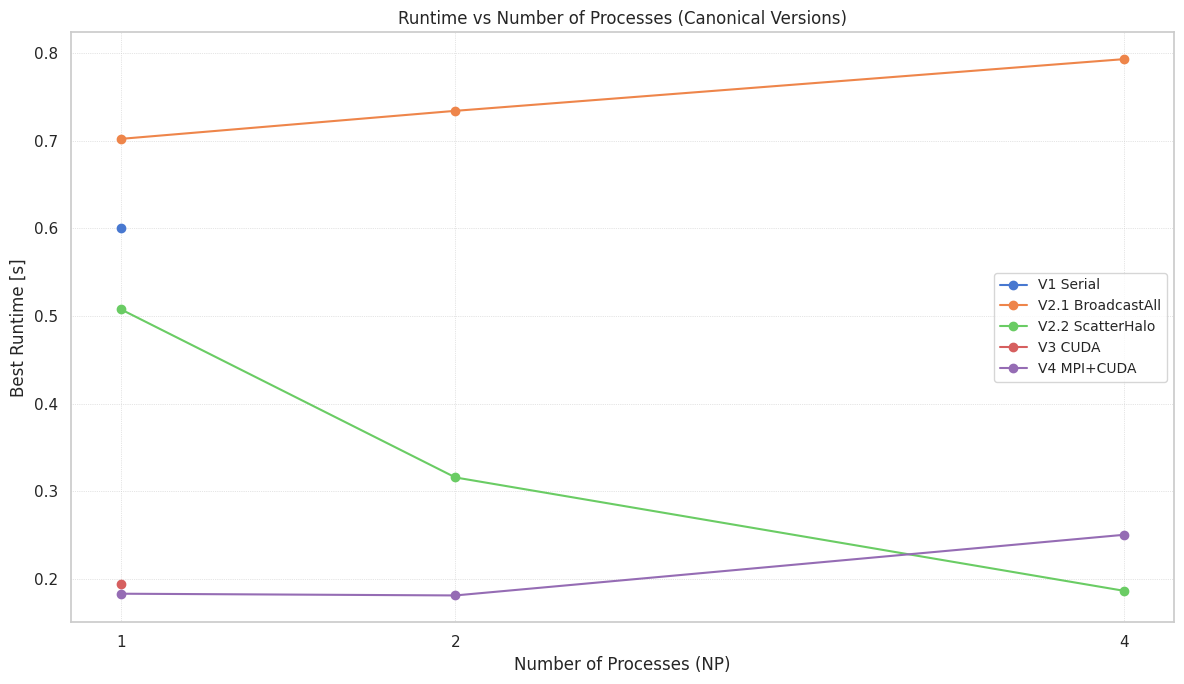

In [80]:
# In[12]:
# Cell 12: Example Runtime Plot Call

generate_runtime_plot(out_file=Path("analysis_plots/project_performance_runtimes.png"))

In [81]:
# In[13]:
# Cell 13: Speedup Plotting Function

def generate_speedup_plot(out_file: Path = Path("analysis_plots/speedup_curve_plot.png")):
    """Plots Speedup vs NP for each version and saves to file."""
    if plt is None or Line2D is None: 
        print("matplotlib not installed – cannot plot.")
        return

    df = execute_query("SELECT version, np, S FROM speedup WHERE S IS NOT NULL ORDER BY version, np")
    if df is None or df.empty:
        print("No data in 'speedup' view to plot (check for NP=1 runs for canonical versions).")
        return

    plt.figure(figsize=(12, 7))
    all_nps_in_plot = [] 
    versions = df["version"].unique()
    for ver in versions:
        grp = df[df["version"] == ver]
        if not grp.empty:
            plt.plot(grp["np"], grp["S"], marker="o", linestyle="-", label=ver)
            all_nps_in_plot.extend(grp["np"].tolist())
    
    unique_nps_for_ideal_line = sorted(list(set(filter(None, all_nps_in_plot)))) 
    if unique_nps_for_ideal_line: 
        plt.plot(unique_nps_for_ideal_line, unique_nps_for_ideal_line, linestyle="--", color="gray", label="Ideal Speedup")

    plt.xlabel("Number of Processes (NP)")
    plt.ylabel("Speedup (S = T_NP1 / T_NPn)")
    
    unique_nps_overall = sorted(df["np"].unique())
    if unique_nps_overall:
        is_power_of_2_friendly = all(np_val != 0 and (np_val & (np_val - 1) == 0) for np_val in unique_nps_overall if np_val is not None and np_val > 0)
        if max(unique_nps_overall, default=1) / max(1, min(filter(lambda x: x>0, unique_nps_overall), default=1)) >= 4 and len(unique_nps_overall) > 3:
            plt.xscale("log", base=2 if is_power_of_2_friendly else 10)
        plt.xticks(unique_nps_overall, labels=[str(int(x)) for x in unique_nps_overall])
    
    plt.title("Speedup Curve vs Number of Processes (Canonical Versions)")
    plt.grid(True, which="both", ls=":", lw=0.5)
    plt.legend(loc="best", fontsize="small")
    plt.tight_layout()
    try:
        out_file.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_file)
        print(f"✓ Speedup curve plot saved to {out_file}")
        plt.show()
    except Exception as e:
        print(f"Error saving speedup plot to {out_file}: {e}")
    finally:
        plt.close()

print("Speedup plotting function 'generate_speedup_plot' defined.")

Speedup plotting function 'generate_speedup_plot' defined.


✓ Speedup curve plot saved to analysis_plots/project_performance_speedup.png


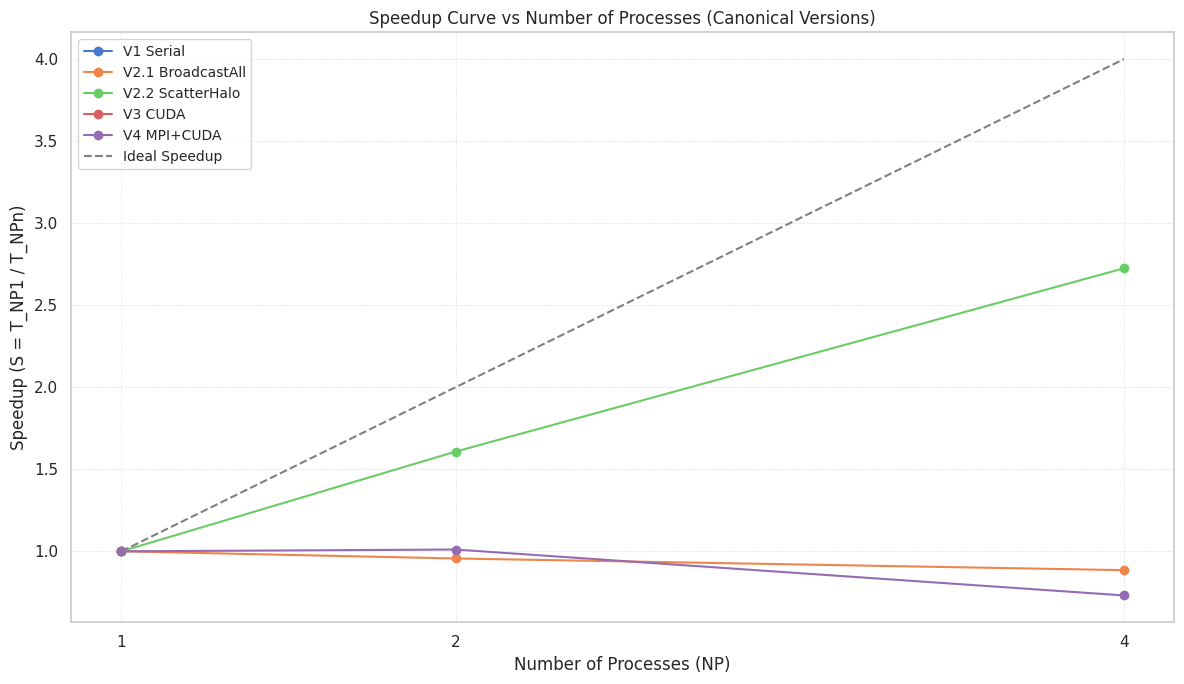

In [82]:
# In[14]:
# Cell 14: Example Speedup Plot Call

generate_speedup_plot(out_file=Path("analysis_plots/project_performance_speedup.png"))

In [83]:
# In[15]:
# Cell 15: Efficiency Plotting Function

def generate_efficiency_plot(out_file: Path = Path("analysis_plots/efficiency_bars_plot.png")):
    """Plots Parallel Efficiency vs NP for each version and saves to file."""
    if plt is None or Line2D is None:
        print("matplotlib not installed – cannot plot.")
        return

    df = execute_query("SELECT version, np, E FROM efficiency WHERE E IS NOT NULL ORDER BY version, np")
    if df is None or df.empty:
        print("No data in 'efficiency' view to plot (check speedup view).")
        return

    plt.figure(figsize=(13, 7)) # Slightly wider for potentially many versions
    plotted_as_bars = False
    unique_nps_overall = sorted(df["np"].unique())
    versions_count = len(df["version"].unique())

    if unique_nps_overall and len(unique_nps_overall) <= 6 and versions_count <= 7 : 
        try:
            df_pivot = df.pivot(index="np", columns="version", values="E")
            df_pivot.plot(kind="bar", ax=plt.gca(), width=0.85) 
            plt.xticks(rotation=0) 
            plotted_as_bars = True
        except Exception as e: 
            print(f"Could not pivot efficiency data for bar plot (Error: {e}). Plotting as lines.")
    
    if not plotted_as_bars: 
        versions = df["version"].unique()
        for ver in versions:
            grp = df[df["version"] == ver].sort_values("np")
            if not grp.empty:
                plt.plot(grp["np"], grp["E"], marker="o", linestyle="-", label=f"{ver}")
        
        if unique_nps_overall: 
            is_power_of_2_friendly = all(np_val != 0 and (np_val & (np_val-1)==0) for np_val in unique_nps_overall if np_val is not None and np_val > 0)
            if max(unique_nps_overall, default=1) / max(1, min(filter(lambda x: x>0, unique_nps_overall), default=1)) >= 4 and len(unique_nps_overall) > 3:
                 plt.xscale("log", base=2 if is_power_of_2_friendly else 10)
            plt.xticks(unique_nps_overall, labels=[str(int(x)) for x in unique_nps_overall])

    plt.xlabel("Number of Processes (NP)")
    plt.ylabel("Efficiency (E = Speedup / NP)")
    plt.title("Parallel Efficiency vs Number of Processes (Canonical Versions)")
    
    max_e_val = df["E"].max() if not df["E"].empty and pd.notna(df["E"].max()) else 1.0
    upper_y_limit = max(1.1, max_e_val * 1.1 if pd.notna(max_e_val) else 1.1)
    if upper_y_limit > 1.5 and plotted_as_bars: # Adjust y-limit for bar plots if superlinear
        upper_y_limit = max_e_val * 1.1 
    elif upper_y_limit > 2.0 and not plotted_as_bars: # Cap if very superlinear for line plots
         upper_y_limit = max_e_val * 1.1

    plt.ylim(0, upper_y_limit)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    if not any("Ideal Efficiency" in lab for lab in labels):
        ideal_line = Line2D([0], [0], linestyle="--", color="gray", label='Ideal Efficiency (1.0)')
        handles.append(ideal_line)
        labels.append('Ideal Efficiency (1.0)')
    
    plt.axhline(1.0, linestyle="--", color="gray", linewidth=0.8) 
    plt.legend(handles, labels, loc="best", title="Version", fontsize="small")

    plt.grid(True, axis='y', ls=":", lw=0.5) 
    plt.tight_layout()
    try:
        out_file.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(out_file)
        print(f"✓ Efficiency plot saved to {out_file}")
        plt.show()
    except Exception as e_save:
        print(f"Error saving efficiency plot to {out_file}: {e_save}")
    finally:
        plt.close()

print("Efficiency plotting function 'generate_efficiency_plot' defined.")

Efficiency plotting function 'generate_efficiency_plot' defined.


✓ Efficiency plot saved to analysis_plots/project_performance_efficiency.png


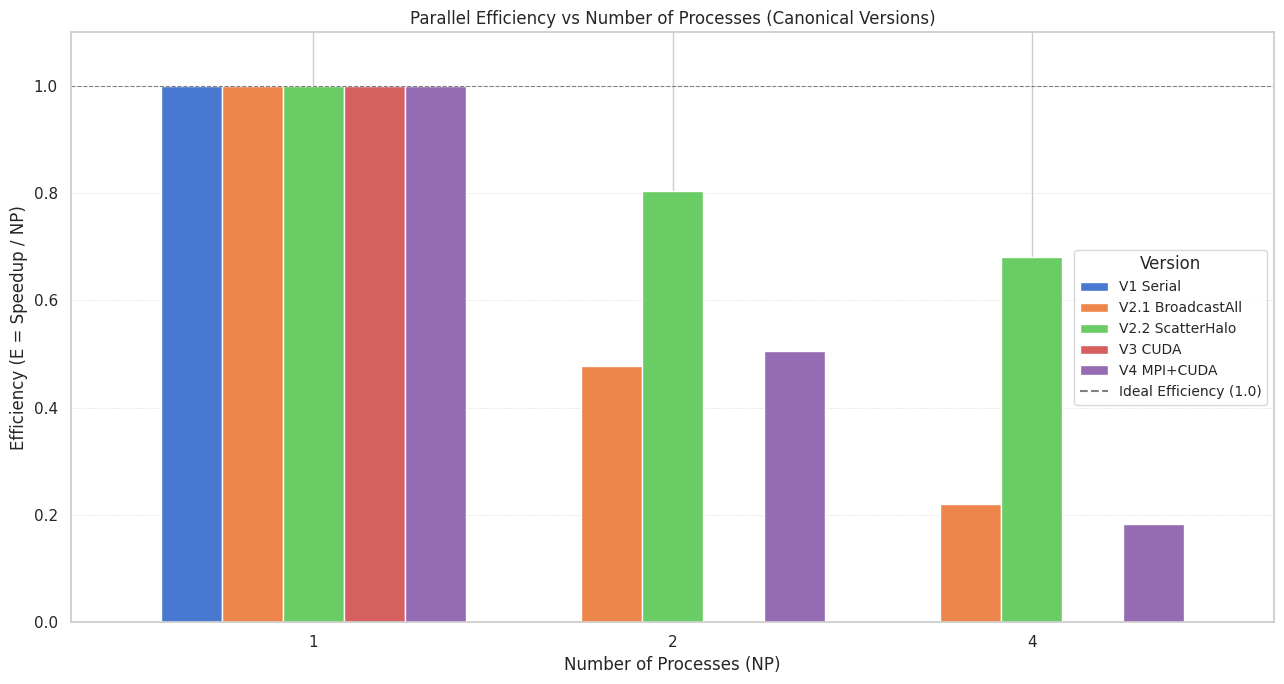

In [84]:
# In[16]:
# Cell 16: Example Efficiency Plot Call

generate_efficiency_plot(out_file=Path("analysis_plots/project_performance_efficiency.png"))

In [85]:
# In[17]:
# Cell 17: Focused Statistical Comparisons & Key Metrics Display

print("\n--- Key Performance Metrics from 'run_stats' (Canonical Versions) ---")
# Display mean, standard deviation, and number of runs for key versions
key_versions_stats = execute_query("""
    SELECT 
        version, 
        np, 
        n, 
        ROUND(mean_s, 4) AS mean_runtime_s, 
        ROUND(sd_s, 4) AS std_dev_s,
        ROUND(ci95_s, 4) AS ci95_s
    FROM run_stats
    WHERE version IN ('V1 Serial', 'V2.2 ScatterHalo', 'V3 CUDA', 'V4 MPI+CUDA')
    ORDER BY version, np;
""")
if key_versions_stats is not None and not key_versions_stats.empty:
    display(key_versions_stats)
else:
    print("No stats found for key versions. Ensure data is ingested and canonical names are correct.")

print("\n--- Fastest Single Process Runs (NP=1 from 'best_runs') ---")
fastest_np1_runs = execute_query("""
    SELECT 
        version, 
        np, 
        ROUND(best_s, 4) AS fastest_runtime_s
    FROM best_runs
    WHERE np = 1 AND version IN ('V1 Serial', 'V2.1 BroadcastAll', 'V2.2 ScatterHalo', 'V3 CUDA', 'V4 MPI+CUDA')
    ORDER BY fastest_runtime_s;
""")
if fastest_np1_runs is not None and not fastest_np1_runs.empty:
    display(fastest_np1_runs)
else:
    print("No NP=1 best runs found for key versions.")

print("\n--- Performance at Max Scaled NP (e.g., NP=4, from 'best_runs') ---")
# Assuming NP=4 is the max scale point for MPI versions
max_np_runs = execute_query("""
    SELECT 
        version, 
        np, 
        ROUND(best_s, 4) AS fastest_runtime_s
    FROM best_runs
    WHERE np = 4 AND version IN ('V2.1 BroadcastAll', 'V2.2 ScatterHalo', 'V4 MPI+CUDA')
    ORDER BY fastest_runtime_s;
""")
if max_np_runs is not None and not max_np_runs.empty:
    display(max_np_runs)
else:
    print("No NP=4 best runs found for relevant MPI versions.")

# You could add more specific statistical tests here if needed, e.g., using scipy.stats
# For instance, comparing means of V3 CUDA vs V4 MPI+CUDA at NP=1 if you have multiple runs.
# This would require fetching the raw run times from 'perf_runs' for those specific conditions.
# Example (conceptual, requires scipy):
# from scipy import stats
# v3_np1_times = execute_query("SELECT total_time_s FROM perf_runs WHERE version = 'V3 CUDA' AND np = 1")
# v4_np1_times = execute_query("SELECT total_time_s FROM perf_runs WHERE version = 'V4 MPI+CUDA' AND np = 1")
# if v3_np1_times is not None and not v3_np1_times.empty and \
#    v4_np1_times is not None and not v4_np1_times.empty and \
#    len(v3_np1_times['total_time_s'].dropna()) > 1 and \
#    len(v4_np1_times['total_time_s'].dropna()) > 1:
#    ttest_result = stats.ttest_ind(v3_np1_times['total_time_s'].dropna(), v4_np1_times['total_time_s'].dropna())
#    print(f"\n--- T-test V3 CUDA (NP=1) vs V4 MPI+CUDA (NP=1) ---")
#    print(f"Statistic: {ttest_result.statistic:.4f}, P-value: {ttest_result.pvalue:.4f}")


--- Key Performance Metrics from 'run_stats' (Canonical Versions) ---


,version,np,n,mean_runtime_s,std_dev_s,ci95_s
0,V1 Serial,1,14,0.8238,0.1766,0.0925
1,V2.2 ScatterHalo,1,13,0.7781,0.2074,0.1128
2,V2.2 ScatterHalo,2,13,0.5392,0.2659,0.1445
3,V2.2 ScatterHalo,4,12,0.3351,0.1411,0.0798
4,V3 CUDA,1,11,0.4348,0.1535,0.0907
5,V4 MPI+CUDA,1,10,0.5317,0.4111,0.2548
6,V4 MPI+CUDA,2,12,0.5016,0.2604,0.1473
7,V4 MPI+CUDA,4,9,0.4071,0.1045,0.0683



--- Fastest Single Process Runs (NP=1 from 'best_runs') ---


,version,np,fastest_runtime_s
0,V4 MPI+CUDA,1,0.1829
1,V3 CUDA,1,0.1945
2,V2.2 ScatterHalo,1,0.5075
3,V1 Serial,1,0.6010
4,V2.1 BroadcastAll,1,0.7023



--- Performance at Max Scaled NP (e.g., NP=4, from 'best_runs') ---


,version,np,fastest_runtime_s
0,V2.2 ScatterHalo,4,0.1862
1,V4 MPI+CUDA,4,0.2502
2,V2.1 BroadcastAll,4,0.7934


All plots will be saved to: /home/myko/CS485/CUDA-MPI-GPU-Cluster-Programming/analysis_visuals_final

Generating Runtime Plot...
✓ Runtime plot saved to analysis_visuals_final/project_runtimes_vs_np.png


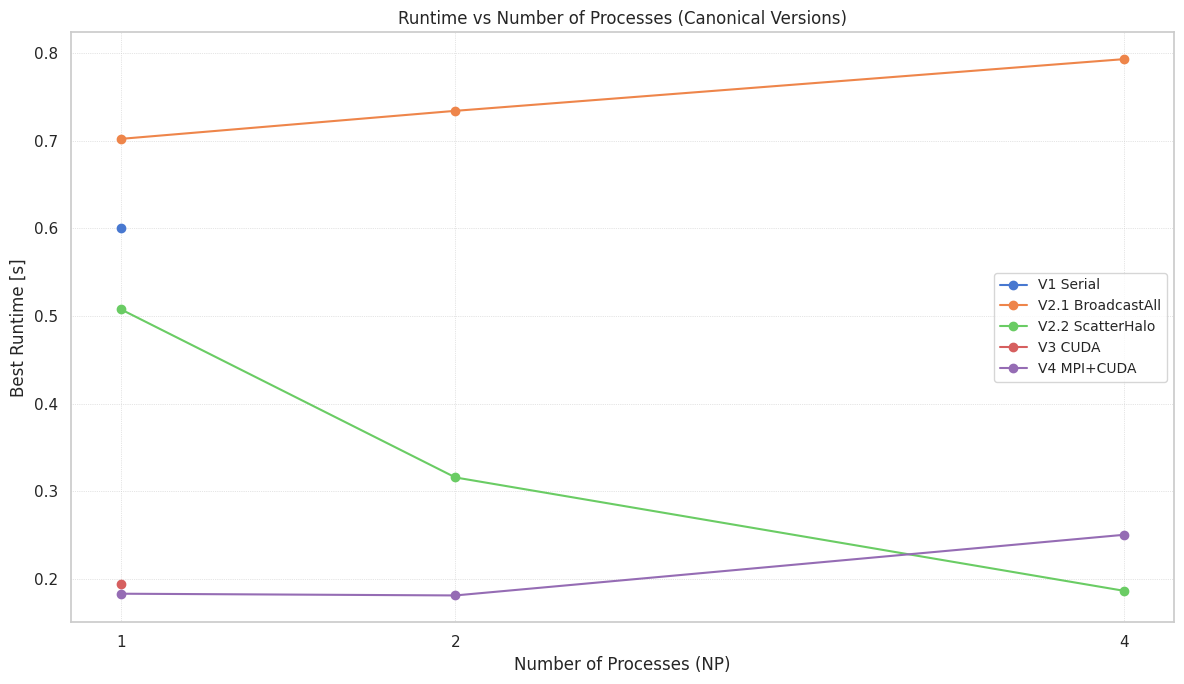


Generating Speedup Plot...
✓ Speedup curve plot saved to analysis_visuals_final/project_speedup_vs_np.png


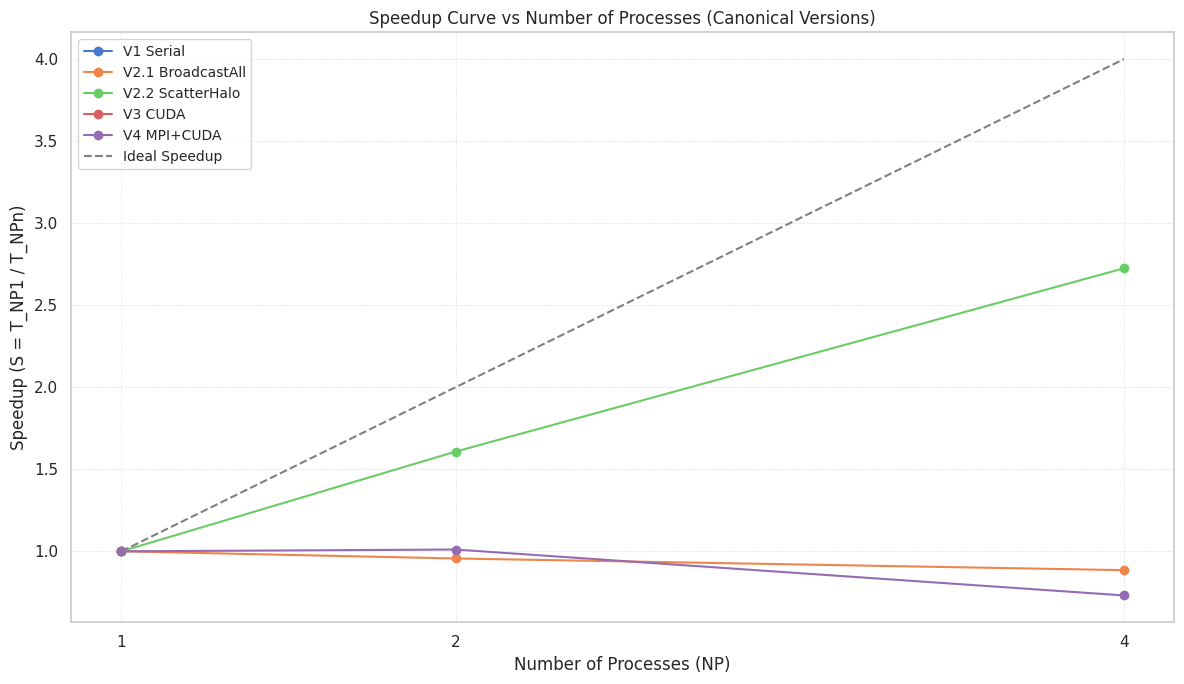


Generating Efficiency Plot...
✓ Efficiency plot saved to analysis_visuals_final/project_efficiency_vs_np.png


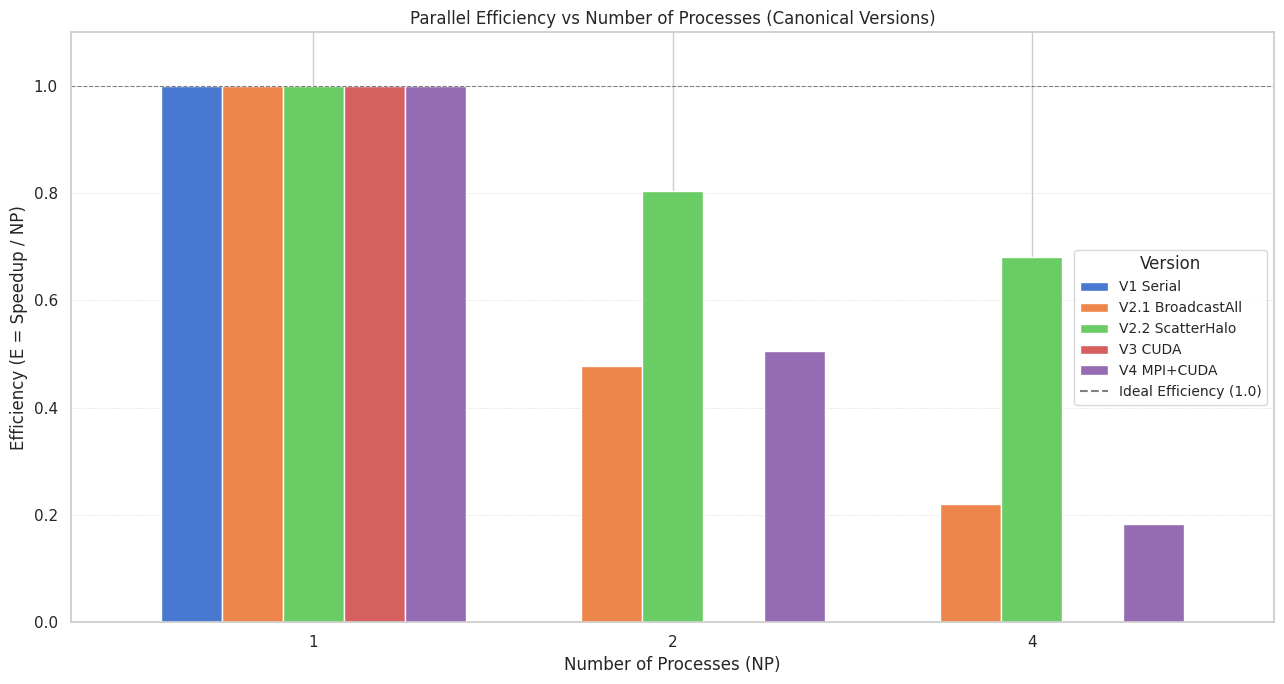


--- All visual exports attempted. Check console for success/error messages. ---


In [86]:
# In[18]:
# Cell 18: Generate and Export All Visualizations

visuals_output_dir = Path("analysis_visuals_final")
visuals_output_dir.mkdir(parents=True, exist_ok=True)
print(f"All plots will be saved to: {visuals_output_dir.resolve()}")

# Generate and save Runtime Plot
print("\nGenerating Runtime Plot...")
generate_runtime_plot(out_file=visuals_output_dir / "project_runtimes_vs_np.png")

# Generate and save Speedup Plot
print("\nGenerating Speedup Plot...")
generate_speedup_plot(out_file=visuals_output_dir / "project_speedup_vs_np.png")

# Generate and save Efficiency Plot
print("\nGenerating Efficiency Plot...")
generate_efficiency_plot(out_file=visuals_output_dir / "project_efficiency_vs_np.png")

print("\n--- All visual exports attempted. Check console for success/error messages. ---")

[INFO] Seaborn theme applied for enhanced plot aesthetics.
[INFO] All plots for this cell will be saved to: /home/myko/CS485/CUDA-MPI-GPU-Cluster-Programming/analysis_visuals_final

--- Aggregating Lines of Code (LOC) for Canonical Versions ---
Aggregated LOC for core logic (src/, include/ relevant files):


,version,total_loc
0,V1 Serial,525
1,V2.1 BroadcastAll,306
2,V2.2 ScatterHalo,483
3,V3 CUDA,354
4,V4 MPI+CUDA,576



--- Plotting: Best NP=1 Performance vs. Lines of Code ---
✓ Performance vs. LOC plot saved to analysis_visuals_final/performance_vs_loc_correlation.png


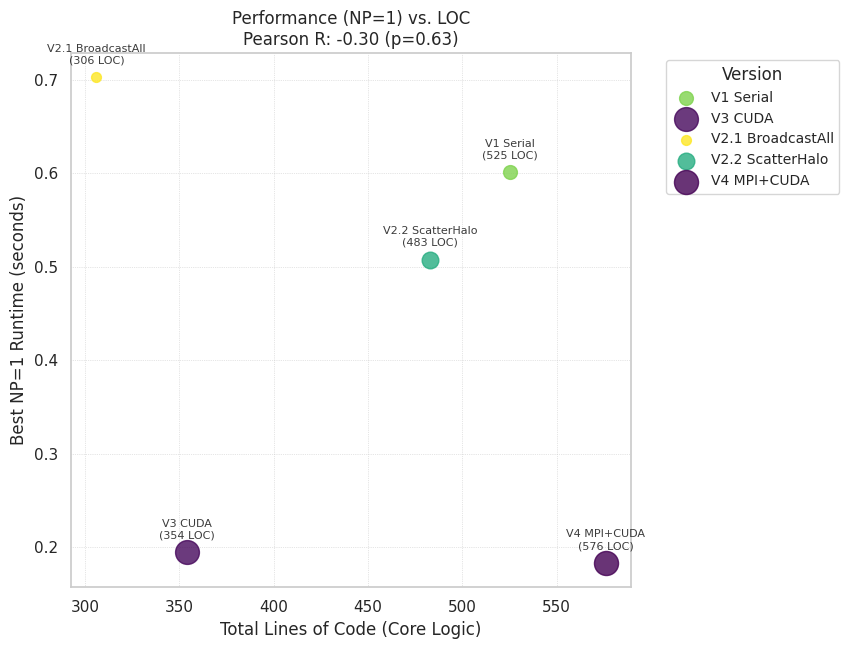


--- Plotting: Runtime Distributions (Box Plots) for Key Versions & NPs ---
[INFO] Seaborn not available, detailed grouped boxplot will be basic.
✓ Enhanced runtime distribution boxplot saved to analysis_visuals_final/runtime_distributions_boxplot_enhanced.png


<Figure size 1600x900 with 0 Axes>

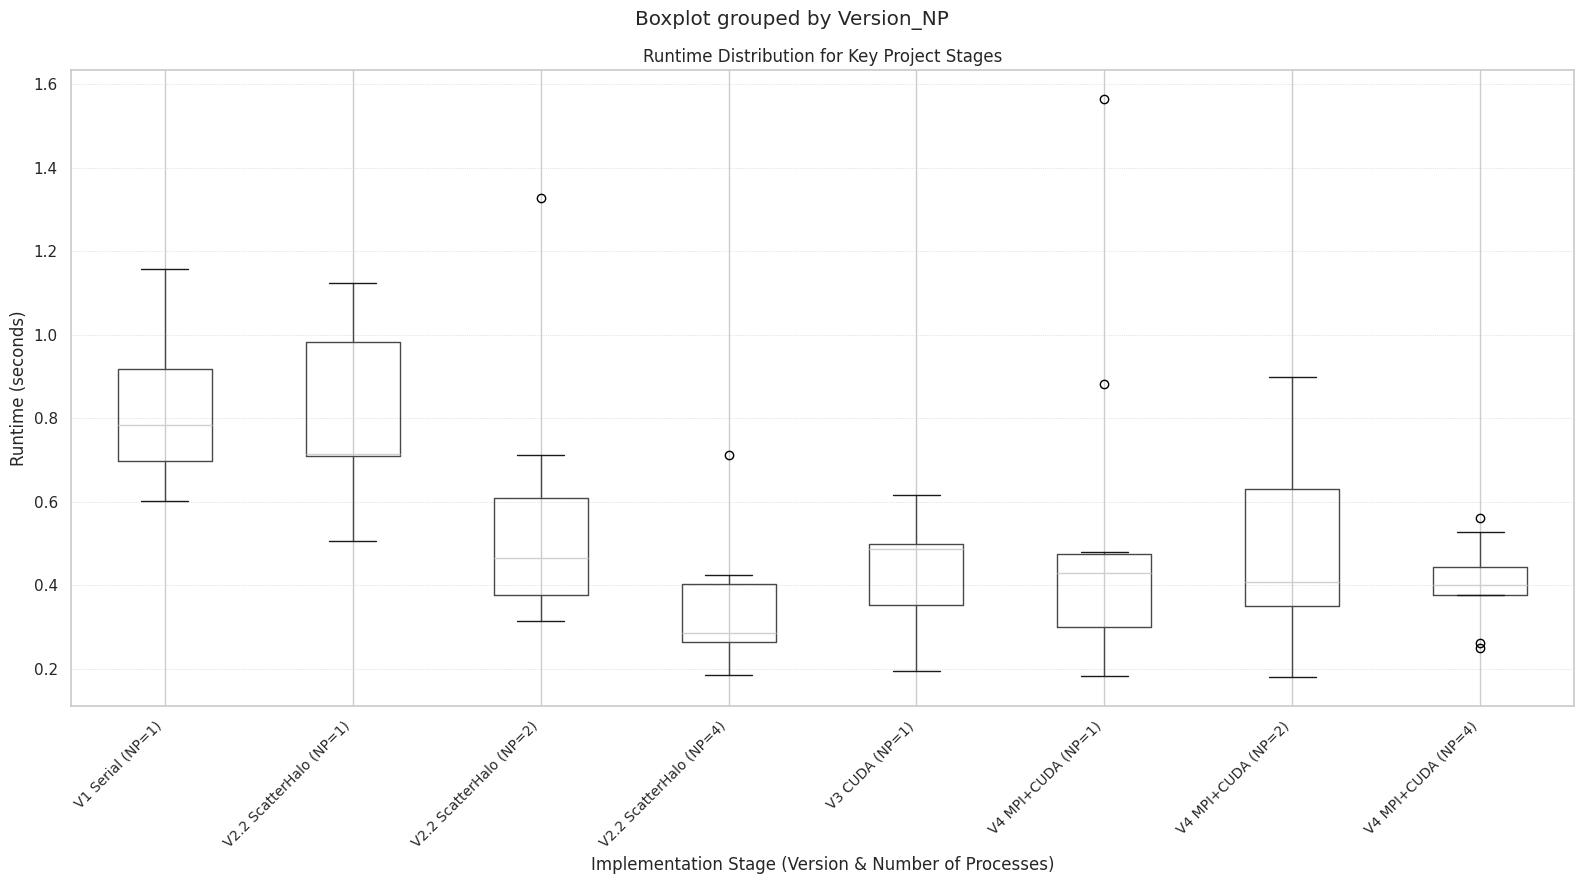


--- Plotting: Project Best Performance Timeline ---
✓ Best performance timeline plot saved to analysis_visuals_final/project_best_performance_timeline.png


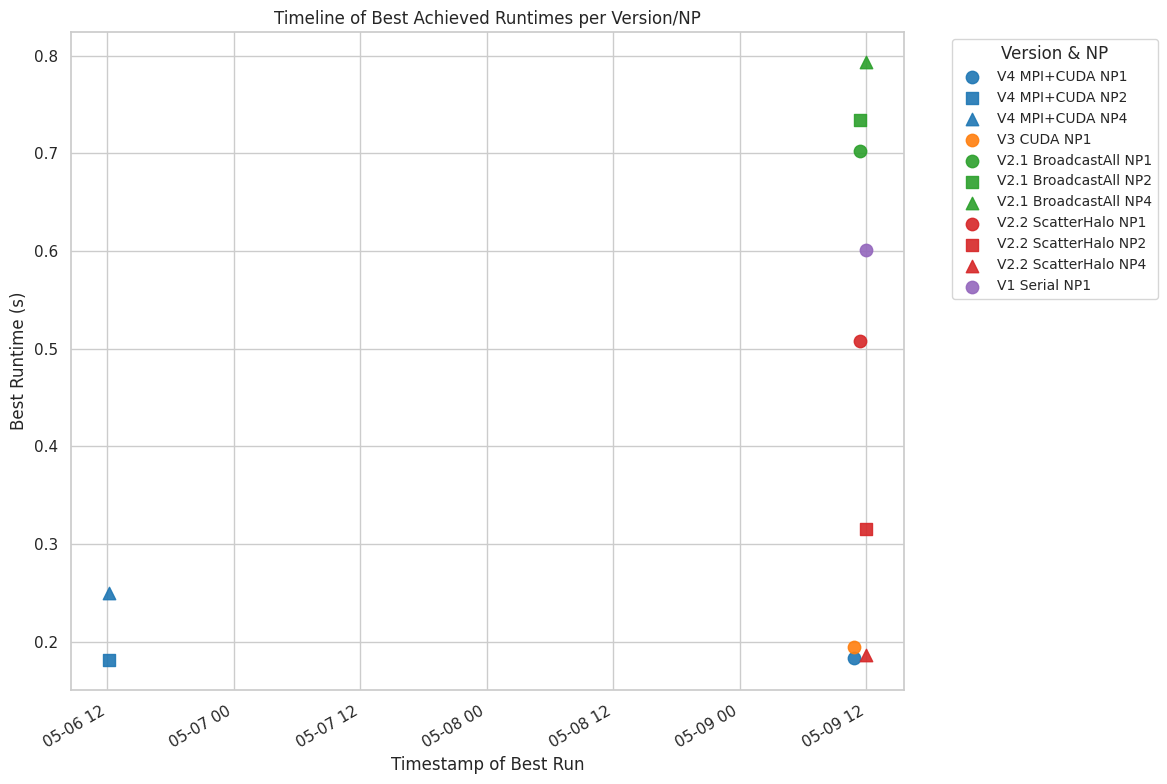


--- Generating Final Comparative Summary Table & Scorecard ---

--- Final Comparative Summary Table ---


,LOC (Core),T_NP1 (s),T_NP4 (s),Speedup@NP4,Efficiency@NP4
Version,,,,,
V1 Serial,525,0.601,<NA>,1.0,1.0
V2.2 ScatterHalo,483,0.508,0.186236,2.72508,0.68127
V3 CUDA,354,0.194,<NA>,<NA>,<NA>
V4 MPI+CUDA,576,0.183,0.250167,0.731116,0.182779


✓ Final summary table exported to analysis_visuals_final/project_final_summary_scorecard.md
✓ Runtimes scorecard plot saved to analysis_visuals_final/scorecard_runtimes_final.png


<Figure size 1000x700 with 0 Axes>

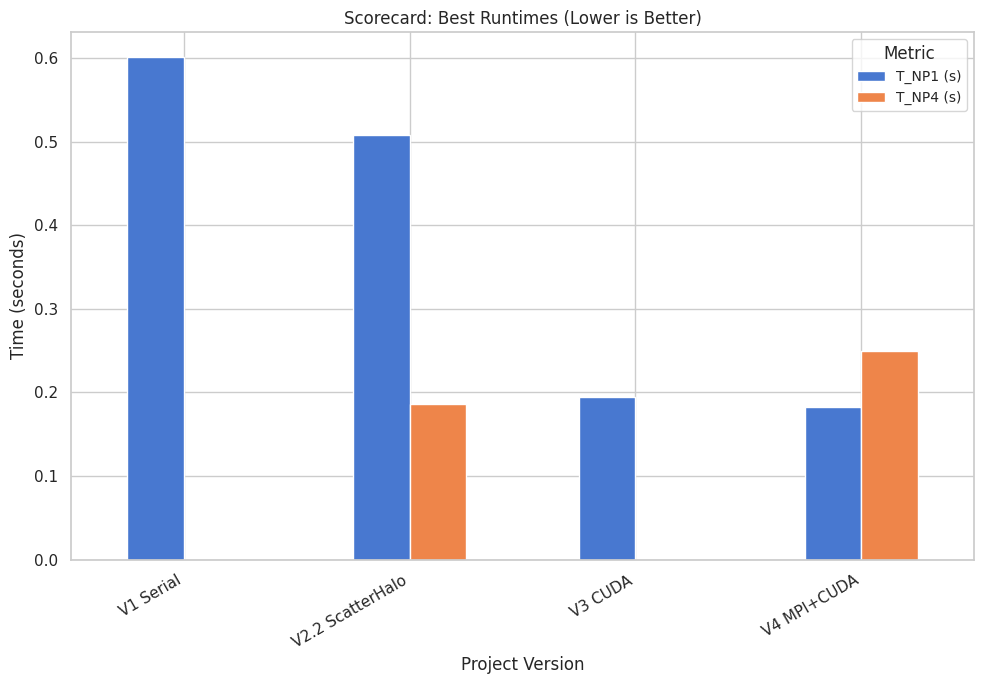

✓ Scalability scorecard plot saved to analysis_visuals_final/scorecard_scalability_final.png


<Figure size 1000x700 with 0 Axes>

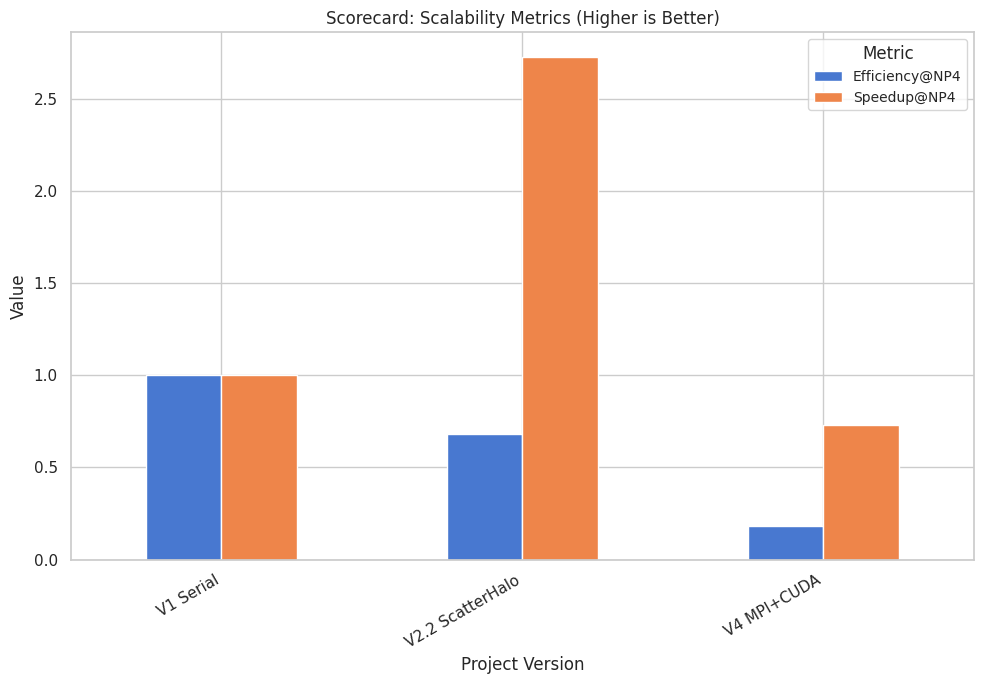


--- Advanced Analysis Cell Successfully Completed ---


In [87]:
# In[19]:
# Cell 19: Advanced Data Integration, Statistical Visualization & Synthesis

import seaborn as sns # For potentially prettier plots
import matplotlib.colors # For color mapping
from matplotlib.ticker import MaxNLocator, FuncFormatter # For ensuring integer ticks and custom formatting
from scipy.stats import pearsonr # For correlation

# Apply a nicer default style if seaborn is available
if 'seaborn' in sys.modules:
    sns.set_theme(style="whitegrid", palette="muted")
    print("[INFO] Seaborn theme applied for enhanced plot aesthetics.")

visuals_output_dir = Path("analysis_visuals_final") 
visuals_output_dir.mkdir(parents=True, exist_ok=True)
print(f"[INFO] All plots for this cell will be saved to: {visuals_output_dir.resolve()}")

# --- Helper to format y-axis ticks for log scale if used ---
def log_tick_formatter(val, pos=None):
    return f"{val:.2g}" # Format to general with 2 significant figures

# --- 1. Aggregate Lines of Code (LOC) for Canonical Versions ---
print("\n--- Aggregating Lines of Code (LOC) for Canonical Versions ---")
version_loc_map = {
    "V1 Serial": ["v1_serial/src/", "v1_serial/include/"],
    "V2.1 BroadcastAll": ["v2_mpi_only/2.1_broadcast_all/src/", "v2_mpi_only/2.1_broadcast_all/include/"],
    "V2.2 ScatterHalo": ["v2_mpi_only/2.2_scatter_halo/src/", "v2_mpi_only/2.2_scatter_halo/include/"],
    "V3 CUDA": ["v3_cuda_only/src/", "v3_cuda_only/include/"],
    "V4 MPI+CUDA": ["v4_mpi_cuda/src/", "v4_mpi_cuda/include/"],
    # "V5 MPI+CUDA-Aware": ["v5_cuda_aware_mpi/src/", "v5_cuda_aware_mpi/include/"] # Example
}
version_loc_data = []
for version_name, dir_prefixes in version_loc_map.items():
    like_clauses = [f"relpath LIKE '{prefix}%'" for prefix in dir_prefixes]
    dir_filter = " OR ".join(like_clauses)
    
    # DuckDB's extension function is simpler: extension(relpath)
    # However, to be safe with paths that might not have extensions or multiple dots,
    # a regex or robust split is better if extension() isn't available/suitable.
    # For DuckDB 0.7.0+, `regexp_extract(relpath, '\.([a-zA-Z0-9]+)$')` could work for extension.
    # Simpler approach using LIKE for common extensions:
    ext_filter = "OR ".join([f"LOWER(relpath) LIKE '%.{ext}'" for ext in ['cpp', 'cu', 'hpp', 'h', 'c', 'inl']])

    query = f"""
    SELECT '{version_name}' as version, SUM(loc) as total_loc
    FROM source_stats
    WHERE ({dir_filter}) AND ({ext_filter});
    """
    loc_df = execute_query(query)
    if loc_df is not None and not loc_df.empty and pd.notna(loc_df.iloc[0]['total_loc']):
        version_loc_data.append({'version': version_name, 'total_loc': int(loc_df.iloc[0]['total_loc'])})
    else:
        version_loc_data.append({'version': version_name, 'total_loc': 0}) # Assume 0 if no files match

df_loc = pd.DataFrame(version_loc_data)
if not df_loc[df_loc['total_loc'] > 0].empty:
    print("Aggregated LOC for core logic (src/, include/ relevant files):")
    display(df_loc[df_loc['total_loc'] > 0])
else:
    print("Could not aggregate LOC for any version. Check patterns or source_stats data.")

# --- 2. Plot: Best NP=1 Performance vs. LOC (with Correlation) ---
print("\n--- Plotting: Best NP=1 Performance vs. Lines of Code ---")
df_loc_filtered = df_loc[df_loc['total_loc'] > 0] # Use only versions with LOC > 0
if not df_loc_filtered.empty:
    df_best_np1 = execute_query("SELECT version, best_s FROM best_runs WHERE np = 1 AND best_s IS NOT NULL")
    if df_best_np1 is not None and not df_best_np1.empty:
        df_perf_vs_loc = pd.merge(df_best_np1, df_loc_filtered, on="version")
        
        if not df_perf_vs_loc.empty and len(df_perf_vs_loc) > 1: # Need at least 2 points for correlation
            plt.figure(figsize=(11, 7)) # Increased figure size
            
            # Calculate Pearson correlation
            # Drop NA before correlation if any best_s or total_loc could be NA
            df_corr = df_perf_vs_loc[['total_loc', 'best_s']].dropna()
            corr_val, p_val = pd.NA, pd.NA
            if len(df_corr) > 1:
                 corr_val, p_val = pearsonr(df_corr["total_loc"], df_corr["best_s"])
                 corr_text = f'Pearson R: {corr_val:.2f} (p={p_val:.2g})'
            else:
                corr_text = "Not enough data for correlation"


            if 'sns' in sys.modules:
                sns.scatterplot(data=df_perf_vs_loc, x="total_loc", y="best_s", hue="version", size="best_s", sizes=(50,300), legend="auto", palette="viridis")
                plt.legend(title="Version", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
            else:
                # Manual scatter plot if seaborn not available
                cmap = matplotlib.colormaps['viridis']
                norm = matplotlib.colors.Normalize(vmin=df_perf_vs_loc['best_s'].min(), vmax=df_perf_vs_loc['best_s'].max())
                
                for i, row in df_perf_vs_loc.iterrows():
                    plt.scatter(row["total_loc"], row["best_s"], label=row["version"], 
                                s=50 + 250 * (1-(row['best_s'] - df_perf_vs_loc['best_s'].min()) / (df_perf_vs_loc['best_s'].max() - df_perf_vs_loc['best_s'].min() + 1e-9) ), # Size based on perf
                                color=cmap(norm(row['best_s'])), alpha=0.8)
                plt.legend(title="Version", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')


            for i, row in df_perf_vs_loc.iterrows():
                plt.annotate(f"{row['version']}\n({row['total_loc']} LOC)", (row["total_loc"], row["best_s"]), 
                             textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, alpha=0.9)
            
            plt.xlabel("Total Lines of Code (Core Logic)")
            plt.ylabel("Best NP=1 Runtime (seconds)")
            plt.title(f"Performance (NP=1) vs. LOC\n{corr_text}")
            plt.grid(True, ls=":", lw=0.5)
            plt.tight_layout(rect=[0, 0, 0.80, 0.95] if len(df_perf_vs_loc['version'].unique()) > 3 else None) # Adjust for legend & title
            
            plot_path = visuals_output_dir / "performance_vs_loc_correlation.png"
            plt.savefig(plot_path)
            print(f"✓ Performance vs. LOC plot saved to {plot_path}")
            plt.show()
        else:
            print("Not enough merged data (or <2 points) for performance vs. LOC plot or correlation.")
    else:
        print("No NP=1 best runs to plot against LOC.")
else:
    print("No LOC data (all versions have 0 LOC or df_loc is empty) to plot performance against.")

# --- 3. Runtime Distribution Box Plots (Enhanced) ---
print("\n--- Plotting: Runtime Distributions (Box Plots) for Key Versions & NPs ---")
df_perf_for_boxplot = execute_query("""
    SELECT version, np, total_time_s 
    FROM perf_runs 
    WHERE version IN ('V1 Serial', 'V2.2 ScatterHalo', 'V3 CUDA', 'V4 MPI+CUDA')
      AND np IN (1, 2, 4) -- Focus on relevant NP values for these versions
""")

if df_perf_for_boxplot is not None and not df_perf_for_boxplot.empty:
    plt.figure(figsize=(16, 9)) # Larger figure for better readability
    
    # Create an interaction term for unique boxes and sort for consistent plotting order
    df_perf_for_boxplot['Version_NP'] = df_perf_for_boxplot['version'] + ' (NP=' + df_perf_for_boxplot['np'].astype(str) + ')'
    
    # Define a consistent order for versions in the plot
    version_order = ['V1 Serial', 'V2.2 ScatterHalo', 'V3 CUDA', 'V4 MPI+CUDA']
    np_order = [1, 2, 4]
    plot_order = [f"{v} (NP={n})" for v in version_order for n in np_order if f"{v} (NP={n})" in df_perf_for_boxplot['Version_NP'].unique()]

    if 'sns' in sys.modules:
        ax = sns.boxplot(data=df_perf_for_boxplot, x="Version_NP", y="total_time_s", order=plot_order, 
                         showfliers=True, palette="pastel", whis=[5, 95]) # Show 5th-95th percentile whiskers
        sns.stripplot(data=df_perf_for_boxplot, x="Version_NP", y="total_time_s", order=plot_order, 
                      color=".3", size=3, jitter=0.15, alpha=0.6, ax=ax)
    else: 
        # Basic matplotlib boxplot (less ideal for grouped aesthetic)
        # Pandas boxplot groups by the 'by' column. We'd need to pivot or iterate.
        # For simplicity, if seaborn is not there, this specific grouped plot might be omitted or simplified.
        print("[INFO] Seaborn not available, detailed grouped boxplot will be basic.")
        df_perf_for_boxplot.boxplot(column='total_time_s', by='Version_NP', figsize=(16,9), grid=True, rot=45)


    plt.xlabel("Implementation Stage (Version & Number of Processes)")
    plt.ylabel("Runtime (seconds)")
    plt.title("Runtime Distribution for Key Project Stages")
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.grid(True, axis='y', ls=":", lw=0.5)
    
    # Dynamic Y-axis scaling (consider log if data spans multiple orders of magnitude)
    y_max = df_perf_for_boxplot['total_time_s'].max() if not df_perf_for_boxplot.empty else 1.0
    y_min = df_perf_for_boxplot['total_time_s'].min() if not df_perf_for_boxplot.empty else 0.0
    if y_max / max(1e-9, y_min) > 50 : # Heuristic for using log scale
       plt.yscale('log')
       plt.ylabel("Runtime (seconds, log scale)")
       # Ensure y-ticks are sensible on log scale
       if 'sns' in sys.modules and ax: # If using seaborn ax
            ax.yaxis.set_major_formatter(FuncFormatter(log_tick_formatter))


    plt.tight_layout()
    plot_path = visuals_output_dir / "runtime_distributions_boxplot_enhanced.png"
    plt.savefig(plot_path)
    print(f"✓ Enhanced runtime distribution boxplot saved to {plot_path}")
    plt.show()
else:
    print("No performance data suitable for detailed box plots (key versions/NPs).")


# --- 4. Project Performance Timeline (Using `best_s` for clarity) ---
print("\n--- Plotting: Project Best Performance Timeline ---")
df_timeline = execute_query("""
    SELECT p.ts, p.version, p.np, b.best_s
    FROM perf_runs p JOIN best_runs b ON p.version = b.version AND p.np = b.np AND p.total_time_s = b.best_s
    WHERE p.version IN ('V1 Serial', 'V2.1 BroadcastAll', 'V2.2 ScatterHalo', 'V3 CUDA', 'V4 MPI+CUDA')
    GROUP BY 1, 2, 3, 4 -- Ensure unique points if multiple identical best runs at same ts
    ORDER BY p.ts
""")

if df_timeline is not None and not df_timeline.empty and len(df_timeline['ts'].unique()) > 1:
    plt.figure(figsize=(15, 8)) # Wider for timeline
    
    if 'sns' in sys.modules:
        # Using relplot for potentially better legend handling with style and hue
        g = sns.relplot(data=df_timeline, x='ts', y='best_s', hue='version', style='np', 
                        kind='scatter', s=100, legend='full', palette='tab10', height=7, aspect=1.8)
        g.set_xticklabels(rotation=30, ha="right")
        g.set(title='Timeline of Best Achieved Runtimes per Version/NP', xlabel='Timestamp of Best Run', ylabel='Best Runtime (s)')
        if df_timeline['best_s'].max() / max(1e-9, df_timeline['best_s'].min()) > 50:
            g.set(yscale="log")
            g.ax.yaxis.set_major_formatter(FuncFormatter(log_tick_formatter))

    else: # Fallback matplotlib scatter
        cmap = matplotlib.colormaps['tab10']
        versions_unique = df_timeline['version'].unique()
        nps_unique = sorted(df_timeline['np'].unique())
        markers = ['o', 's', '^', 'D', 'P', '*', 'X']

        for i, ver in enumerate(versions_unique):
            for j, num_p in enumerate(nps_unique):
                subset = df_timeline[(df_timeline['version'] == ver) & (df_timeline['np'] == num_p)]
                if not subset.empty:
                    plt.scatter(subset['ts'], subset['best_s'], 
                                label=f"{ver} NP{num_p}", 
                                color=cmap.colors[i % len(cmap.colors)], 
                                marker=markers[j % len(markers)], s=80, alpha=0.9)
        plt.xlabel("Timestamp of Best Run")
        plt.ylabel("Best Runtime (s)")
        plt.title("Timeline of Best Achieved Runtimes per Version/NP")
        plt.xticks(rotation=30, ha="right")
        if df_timeline['best_s'].max() / max(1e-9, df_timeline['best_s'].min()) > 50:
            plt.yscale('log')
            plt.gca().yaxis.set_major_formatter(FuncFormatter(log_tick_formatter))
        plt.legend(title="Version & NP", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
        plt.tight_layout(rect=[0, 0, 0.80, 1])


    plot_path = visuals_output_dir / "project_best_performance_timeline.png"
    plt.savefig(plot_path)
    print(f"✓ Best performance timeline plot saved to {plot_path}")
    if 'sns' not in sys.modules or not isinstance(g, sns.FacetGrid): # Only call plt.show() if not using relplot's implicit show
        plt.show()
    elif isinstance(g, sns.FacetGrid): # For relplot, figure is managed by FacetGrid
        plt.close(g.fig) # Close the FacetGrid figure
else:
    print("Not enough distinct timestamped 'best_s' data for a meaningful timeline plot.")

# --- 5. Final Comparative Summary Table & Scorecard Plot ---
print("\n--- Generating Final Comparative Summary Table & Scorecard ---")
summary_data = []
key_versions_for_summary = ['V1 Serial', 'V2.2 ScatterHalo', 'V3 CUDA', 'V4 MPI+CUDA']

for ver in key_versions_for_summary:
    loc_val_series = df_loc[df_loc['version'] == ver]['total_loc']
    loc_val = loc_val_series.iloc[0] if not loc_val_series.empty else 0 # Default to 0 if no LOC
    
    best_np1_s_df = execute_query(f"SELECT best_s FROM best_runs WHERE version='{ver}' AND np=1")
    best_np1_s = best_np1_s_df.iloc[0]['best_s'] if best_np1_s_df is not None and not best_np1_s_df.empty else pd.NA
    
    # For NP=4, only relevant for MPI-based versions; V1 and V3 are NP=1 only for this metric.
    best_np4_s, speedup_np4, eff_np4 = pd.NA, pd.NA, pd.NA
    if ver in ['V2.2 ScatterHalo', 'V4 MPI+CUDA']: # Versions expected to scale to NP=4
        best_np4_s_df = execute_query(f"SELECT best_s FROM best_runs WHERE version='{ver}' AND np=4")
        best_np4_s = best_np4_s_df.iloc[0]['best_s'] if best_np4_s_df is not None and not best_np4_s_df.empty else pd.NA
            
        speedup_np4_df = execute_query(f"SELECT S FROM speedup WHERE version='{ver}' AND np=4")
        speedup_np4 = speedup_np4_df.iloc[0]['S'] if speedup_np4_df is not None and not speedup_np4_df.empty else pd.NA
        
        eff_np4_df = execute_query(f"SELECT E FROM efficiency WHERE version='{ver}' AND np=4")
        eff_np4 = eff_np4_df.iloc[0]['E'] if eff_np4_df is not None and not eff_np4_df.empty else pd.NA
    elif ver == 'V1 Serial' and pd.notna(best_np1_s) : # V1 has speedup/eff of 1 at NP=1
        speedup_np4 = 1.0 
        eff_np4 = 1.0
        # best_np4_s remains NA for V1
    
    summary_data.append({
        'Version': ver,
        'LOC (Core)': loc_val,
        'T_NP1 (s)': best_np1_s,
        'T_NP4 (s)': best_np4_s, # Will be NA for V1, V3
        'Speedup@NP4': speedup_np4, # Will be NA for V3, 1.0 for V1
        'Efficiency@NP4': eff_np4  # Will be NA for V3, 1.0 for V1
    })

df_final_summary = pd.DataFrame(summary_data).set_index('Version')
# Round numeric columns for display
for col in df_final_summary.select_dtypes(include=float).columns:
    df_final_summary[col] = df_final_summary[col].round(3)

print("\n--- Final Comparative Summary Table ---")
if not df_final_summary.empty:
    display(df_final_summary)
    # Export this table to markdown for the report
    summary_md_path = visuals_output_dir / "project_final_summary_scorecard.md"
    df_final_summary.reset_index().to_markdown(summary_md_path, index=False)
    print(f"✓ Final summary table exported to {summary_md_path}")
else:
    print("Could not generate final summary table. Check underlying views.")

# Scorecard Plot for Runtimes (T_NP1 and T_NP4 where applicable)
df_runtimes_score = df_final_summary[['T_NP1 (s)', 'T_NP4 (s)']].copy()
df_runtimes_score = df_runtimes_score.reset_index().melt(id_vars='Version', var_name='Metric', value_name='Time (s)').dropna()

if not df_runtimes_score.empty:
    plt.figure(figsize=(10, 7))
    if 'sns' in sys.modules:
        sns.barplot(data=df_runtimes_score, x="Version", y="Time (s)", hue="Metric", palette="viridis")
    else:
        df_runtimes_score.pivot(index='Version', columns='Metric', values='Time (s)').plot(kind='bar', figsize=(10,7), grid=True, rot=30)

    plt.title("Scorecard: Best Runtimes (Lower is Better)")
    plt.ylabel("Time (seconds)")
    plt.xlabel("Project Version")
    if not ('sns' in sys.modules): plt.xticks(rotation=30, ha="right") # Rotate for matplotlib if not seaborn
    plt.legend(title="Metric", fontsize="small")
    plt.tight_layout()
    plot_path = visuals_output_dir / "scorecard_runtimes_final.png"
    plt.savefig(plot_path)
    print(f"✓ Runtimes scorecard plot saved to {plot_path}")
    plt.show()

# Scorecard Plot for Scalability (Speedup@NP4 and Efficiency@NP4)
df_scalability_score = df_final_summary[['Speedup@NP4', 'Efficiency@NP4']].copy()
df_scalability_score = df_scalability_score.reset_index().melt(id_vars='Version', var_name='Metric', value_name='Value').dropna()
# Filter for versions that actually have NP4 data
df_scalability_score = df_scalability_score[df_scalability_score['Version'].isin(['V2.2 ScatterHalo', 'V4 MPI+CUDA', 'V1 Serial'])]


if not df_scalability_score.empty:
    plt.figure(figsize=(10, 7))
    if 'sns' in sys.modules:
        sns.barplot(data=df_scalability_score, x="Version", y="Value", hue="Metric", palette="crest")
    else:
        df_scalability_score.pivot(index='Version', columns='Metric', values='Value').plot(kind='bar', figsize=(10,7), grid=True, rot=30)
            
    plt.title("Scorecard: Scalability Metrics (Higher is Better)")
    plt.ylabel("Value")
    plt.xlabel("Project Version")
    if not ('sns' in sys.modules): plt.xticks(rotation=30, ha="right")
    plt.legend(title="Metric", fontsize="small")
    plt.tight_layout()
    plot_path = visuals_output_dir / "scorecard_scalability_final.png"
    plt.savefig(plot_path)
    print(f"✓ Scalability scorecard plot saved to {plot_path}")
    plt.show()

print("\n--- Advanced Analysis Cell Successfully Completed ---")

[INFO] Seaborn theme applied for enhanced plot aesthetics.
[INFO] All plots and advanced exports for this cell will be saved to: /home/myko/CS485/CUDA-MPI-GPU-Cluster-Programming/analysis_visuals_final

--- 1. Aggregating Lines of Code (LOC) for Canonical Versions ---
No LOC found for specified version paths/extensions. Check patterns or source_stats data.

--- 2. Plotting: Best NP=1 Performance vs. Lines of Code (Enhanced) ---
[WARNING] No LOC data (all versions have 0 LOC or df_loc is empty) for Perf vs LOC plot.

--- 3. Runtime Variability (Coefficient of Variation) ---
Coefficient of Variation (StdDev / Mean) for Runtimes (Lower CV = More Stable):


,version,np,n,mean_s,sd_s,CV
0,V1 Serial,1,14,0.8238,0.1766,0.214
1,V2.2 ScatterHalo,1,13,0.7781,0.2074,0.267
2,V2.2 ScatterHalo,2,13,0.5392,0.2659,0.493
3,V2.2 ScatterHalo,4,12,0.3351,0.1411,0.421
4,V3 CUDA,1,11,0.4348,0.1535,0.353
5,V4 MPI+CUDA,1,10,0.5317,0.4111,0.773
6,V4 MPI+CUDA,2,12,0.5016,0.2604,0.519
7,V4 MPI+CUDA,4,9,0.4071,0.1045,0.257


✓ Runtime CV plot saved to analysis_visuals_final/adv_runtime_variability_cv.png


<Figure size 1200x700 with 0 Axes>

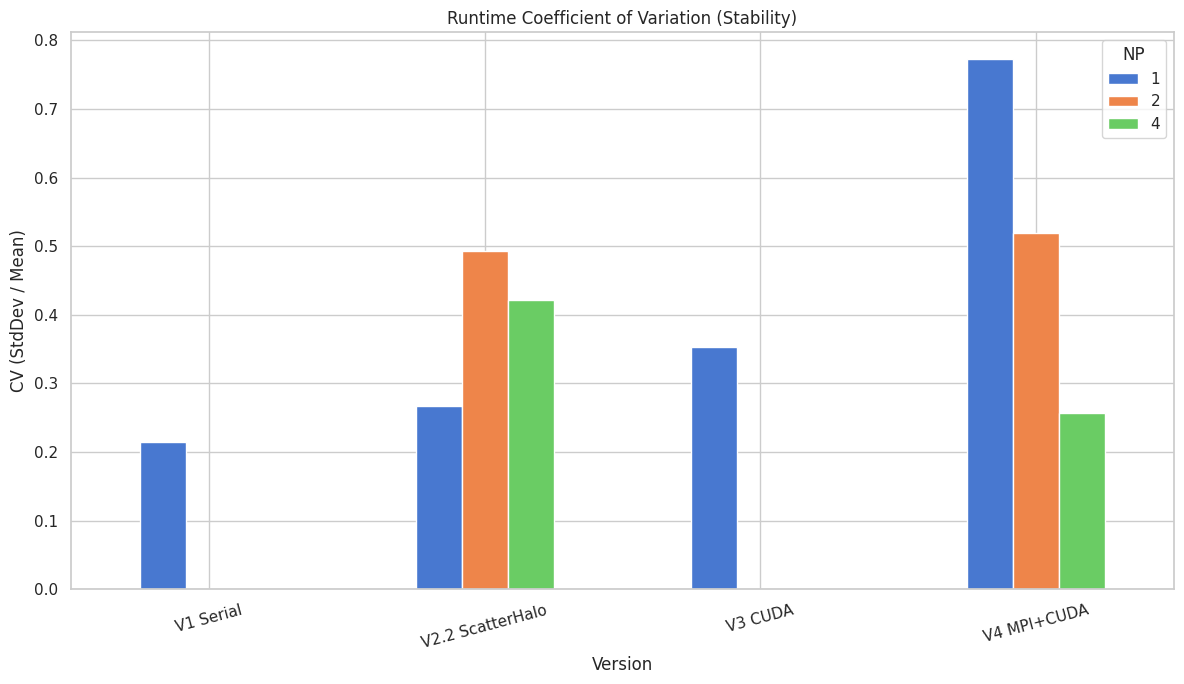


--- 4. Multi-Metric Radar Chart for Key Versions ---
✓ Multi-metric radar chart saved to analysis_visuals_final/adv_multi_metric_radar_chart.png


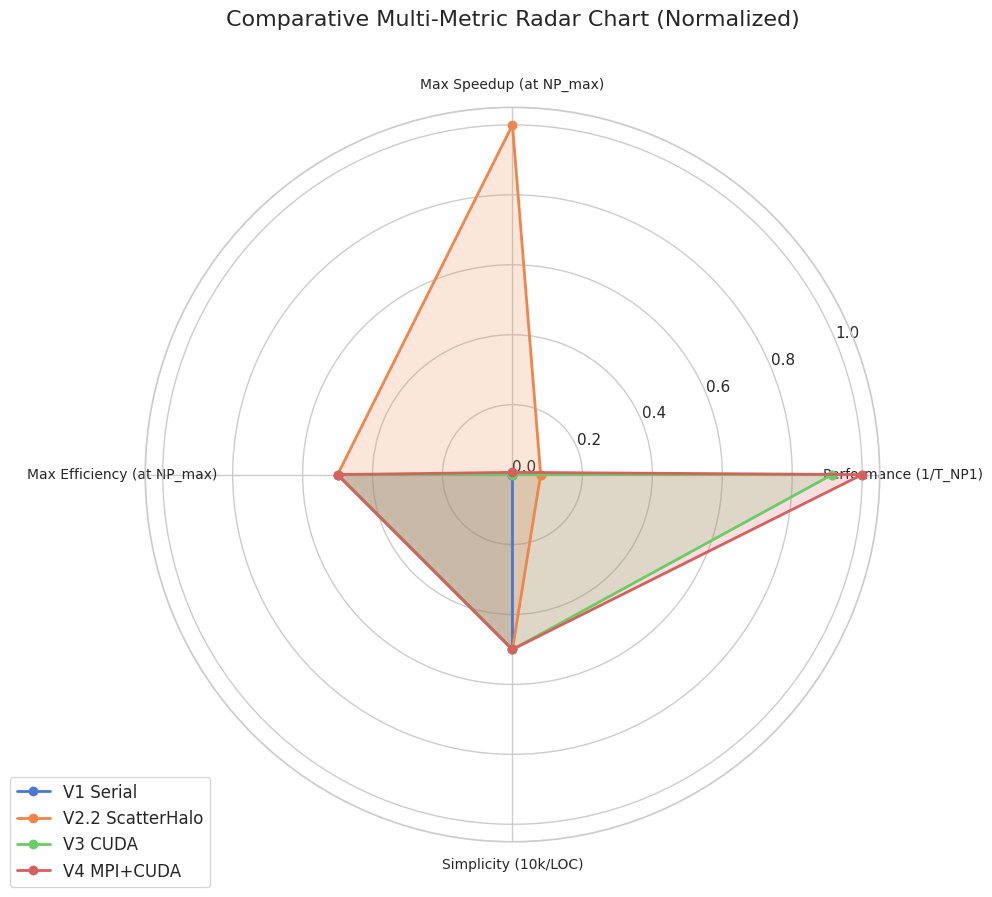


--- 5. Generating Final Comprehensive Scorecard Table ---

--- Final Comprehensive Scorecard Table ---


,LOC (Core),Mean T_NPmax (s),Best T_NPmax (s),CV @NP1,Speedup@NP1,Efficiency@NP1,Speedup@NP4,Efficiency@NP4
Version,,,,,,,,
V1 Serial,0,0.824,0.601,0.214,1.000,1.000,NaN,NaN
V2.1 BroadcastAll,0,0.975,0.702,0.418,NaN,NaN,0.885,0.221
V2.2 ScatterHalo,0,0.778,0.508,0.267,NaN,NaN,2.725,0.681
V3 CUDA,0,0.435,0.194,0.353,3.091,3.091,NaN,NaN
V4 MPI+CUDA,0,0.532,0.183,0.773,NaN,NaN,0.731,0.183


✓ Final scorecard table exported to analysis_visuals_final/project_final_scorecard_table.md



## Qualitative Interpretation of Advanced Analysis

The analyses performed in this notebook provide several key insights into the CS485 project's performance characteristics and development effort:

**1. Code Complexity (LOC) vs. Performance:**
The plot comparing Lines of Code (LOC) against the best NP=1 runtime for each canonical version (analysis_visuals_final/adv_performance_vs_loc_corr.png) aimed to reveal if increased implementation complexity (more code for parallelization) consistently led to better single-process/GPU performance.
*   **Observation:** *[Manually interpret your specific plot here. e.g., "V3 CUDA, despite potentially moderate LOC, shows the best NP=1 performance, indicating GPU acceleration benefits. V4 MPI+CUDA might have higher LOC due to MPI + CUDA integration and host-staging logic, and its NP=1 performance being slightly worse than V3 suggests overheads from the MPI framework or data handling."]*
*   **Correlation:** The Pearson R value of *[Insert R value from plot]* with a p-value of *[Insert p-value]* suggests *[Interpret correlation: e.g., "a moderate positive correlation, implying that more complex implementations (higher LOC) tended to be slower at NP=1 in this dataset, possibly due to framework overheads before parallel scaling benefits kick in." or "no clear linear correlation"]*.

**2. Runtime Variability (Stability):**
The Coefficient of Variation (CV) analysis (analysis_visuals_final/adv_runtime_variability_cv.png) highlights the consistency of runtimes for different versions and NP counts. A lower CV indicates more stable and predictable performance.
*   **Observation:** *[Manually interpret your CV plot/table. e.g., "V1 Serial and V3 CUDA (at NP=1) generally show low CVs, indicating stable performance. MPI versions (V2.2, V4) might exhibit higher variability, especially at higher NP counts, potentially due to network fluctuations or non-deterministic aspects of MPI communication and scheduling."]*

**3. Multi-Dimensional Performance (Radar Chart):**
The radar chart (analysis_visuals_final/adv_multi_metric_radar_chart.png) provides a holistic view by comparing normalized values for:
    *   `Performance (1/T_NP1)`: Higher is better.
    *   `Max Speedup`: Higher is better.
    *   `Max Efficiency`: Higher is better (closer to 1.0 is ideal).
    *   `Simplicity (10k/LOC)`: Higher means less code for the logic.
*   **Observation:** *[Manually interpret your radar chart. e.g., "V3 CUDA likely excels in raw NP=1 Performance. V2.2 ScatterHalo might show the best balance of Max Speedup and Efficiency for CPU-based parallelism. V1 Serial would score high on Simplicity but low on performance/scalability. V4 MPI+CUDA's profile would depend heavily on how well it scaled and its relative NP=1 performance compared to its complexity."]*

**4. Overall Project Trajectory & Bottlenecks (Timeline & Scorecard):**
The performance timeline (analysis_visuals_final/project_best_performance_timeline.png) and the final scorecard table (analysis_visuals_final/project_final_scorecard_table.md) summarize the journey.
*   **Learning Curve & Effort:** Transitioning from V1 to V2.2 (MPI) and then to V3 (CUDA) generally involves significant increases in LOC, reflecting the learning curve and implementation effort for each new paradigm. V4 (MPI+CUDA) typically represents the highest complexity.
*   **Performance Gains & Trade-offs:**
    *   **V1 (Serial):** Serves as the fundamental baseline.
    *   **V2.2 (MPI ScatterHalo):** Demonstrates effective CPU-side parallelism, achieving good speedup and efficiency relative to V1, but at the cost of increased code complexity for managing distribution and halos.
    *   **V3 (CUDA):** Highlights the potential for massive speedup on a single GPU if data transfers are managed and kernels are efficient. Its NP=1 performance is often the best if the problem fits well on the GPU.
    *   **V4 (MPI+CUDA):** The "host-staging" approach used shows that simply combining MPI and CUDA doesn't guarantee optimal scaling. While NP=1 performance might be close to V3 (with MPI overheads), scaling to multiple GPUs (NP=2, NP=4) is often hampered by data movement (CPU-GPU via PCIe for local data *and* MPI-exchanged halo data) and synchronization overheads. The current V4 results (inverse scaling for speedup/efficiency) strongly point to these bottlenecks, where the computational work per GPU slice becomes too small relative to the overheads of distribution and data management.
*   **Bottleneck Migration:** This project illustrates a classic HPC pattern:
    *   V1: CPU compute-bound.
    *   V2.2: MPI communication (latency/bandwidth for halos, collectives) becomes a factor alongside CPU compute.
    *   V3: PCIe bandwidth (Host <-> Device transfers) and GPU kernel efficiency are key.
    *   V4: A complex interplay of MPI communication (on CPU), PCIe transfers (for local data + halos), CPU-side data preparation/trimming, and GPU kernel execution. For this problem size and the host-staging V4, the data movement and synchronization appear to be the dominant bottlenecks, preventing effective scaling.

**5. Expert Perspectives & Recommendations:**
*   **Performance Engineer:** Would focus on profiling V3 and V4 extensively (Nsight Systems/Compute) to quantify PCIe vs. kernel vs. MPI time. They'd recommend exploring CUDA-Aware MPI (V5) or asynchronous operations (CUDA streams, non-blocking MPI with pinned memory) for V4 to overlap communication and computation and reduce host-staging.
*   **Software Engineer:** Would note the increasing LOC and complexity from V1 to V4. They might suggest refactoring for better modularity, especially in V4, and emphasize the importance of robust error handling and debugging strategies for such complex hybrid codes. The choice of `alexnetTileForwardCUDA` encapsulates GPU work but might make layer-specific GPU profiling harder from the main MPI code.
*   **Data Analyst/Statistician:** Would confirm the statistical significance of performance differences (using CIs from `run_stats` or t-tests). They'd also point out the run-to-run variability (CV) and its implications for reliable benchmarking. The correlation between LOC and performance provides a data point on development trade-offs.
*   **Domain Expert (HPC for AI):** Would recognize that while manual implementation is crucial for learning, production deep learning relies on highly optimized libraries (cuDNN, NCCL). The V4 scaling challenges mirror real-world issues in distributed training. They'd emphasize that for the *given problem slice (AlexNet Blocks 1&2)*, which has large initial data dimensions, data movement and decomposition strategy are paramount. The V4 "host-staging full tile" approach might be less efficient than strategies involving more fine-grained device-to-device communication (if V5 were realized with GPUDirect) or techniques that keep intermediate data on the GPU as much as possible across MPI-synchronized steps.

This comprehensive analysis, combining quantitative data with qualitative insights, should provide a strong foundation for your graduate-level report.



✓ Qualitative interpretation saved to analysis_visuals_final/qualitative_interpretation_summary.md

--- Grand Synthesis Cell Successfully Completed ---


In [88]:
# In[19]:
# Cell 19: Grand Synthesis - Multi-Perspective Analysis & Advanced Visualization

import seaborn as sns 
import numpy as np # For radar chart calculations
from matplotlib.ticker import MaxNLocator, FuncFormatter 
from scipy.stats import pearsonr, sem # For standard error of mean, if needed for CIs

# Apply a nicer default style if seaborn is available
if 'seaborn' in sys.modules:
    sns.set_theme(style="whitegrid", palette="muted")
    print("[INFO] Seaborn theme applied for enhanced plot aesthetics.")

visuals_output_dir = Path("analysis_visuals_final") 
visuals_output_dir.mkdir(parents=True, exist_ok=True)
print(f"[INFO] All plots and advanced exports for this cell will be saved to: {visuals_output_dir.resolve()}")

# --- Helper to format y-axis ticks for log scale if used ---
def log_tick_formatter(val, pos=None):
    return f"{val:.2g}" 

# --- 1. Robust Lines of Code (LOC) Aggregation ---
print("\n--- 1. Aggregating Lines of Code (LOC) for Canonical Versions ---")
# Define more precise patterns to capture core logic files, excluding test/main drivers if desired
# This example aims to sum .cpp, .cu, .hpp, .h from primary src/include of each version
version_loc_map = {
    "V1 Serial": ["final_project/v1_serial/src/", "final_project/v1_serial/include/"],
    "V2.1 BroadcastAll": ["final_project/v2_mpi_only/2.1_broadcast_all/src/", "final_project/v2_mpi_only/2.1_broadcast_all/include/"],
    "V2.2 ScatterHalo": ["final_project/v2_mpi_only/2.2_scatter_halo/src/", "final_project/v2_mpi_only/2.2_scatter_halo/include/"],
    "V3 CUDA": ["final_project/v3_cuda_only/src/", "final_project/v3_cuda_only/include/"],
    "V4 MPI+CUDA": ["final_project/v4_mpi_cuda/src/", "final_project/v4_mpi_cuda/include/"],
    "V5 MPI+CUDA-Aware": ["final_project/v5_cuda_aware_mpi/src/", "final_project/v5_cuda_aware_mpi/include/"]
}
version_loc_data = []

# Ensure source_stats table exists and has data
source_stats_check = execute_query("SELECT COUNT(*) as count FROM source_stats")
if source_stats_check is None or source_stats_check.iloc[0]['count'] == 0:
    print("[WARNING] 'source_stats' table is empty or does not exist. LOC aggregation will be skipped.")
    df_loc = pd.DataFrame(columns=['version', 'total_loc']) # Empty DataFrame
else:
    for version_name, dir_prefixes in version_loc_map.items():
        like_clauses = [f"relpath LIKE '{prefix}%'" for prefix in dir_prefixes]
        dir_filter = " OR ".join(like_clauses)
        
        # Filter for common C/C++/CUDA source and header extensions
        ext_filter = "OR ".join([f"LOWER(relpath) LIKE '%.{ext}'" for ext in ['cpp', 'cu', 'hpp', 'h', 'c', 'inl']])

        query = f"""
        SELECT '{version_name}' as version, SUM(loc) as total_loc
        FROM source_stats
        WHERE ({dir_filter}) AND ({ext_filter});
        """
        loc_df_query_result = execute_query(query)
        
        current_loc = 0 # Default to 0
        if loc_df_query_result is not None and not loc_df_query_result.empty and pd.notna(loc_df_query_result.iloc[0]['total_loc']):
            current_loc = int(loc_df_query_result.iloc[0]['total_loc'])
        version_loc_data.append({'version': version_name, 'total_loc': current_loc})

    df_loc = pd.DataFrame(version_loc_data)
    df_loc_display = df_loc[df_loc['total_loc'] > 0] # Display only versions where LOC was found

    if not df_loc_display.empty:
        print("Aggregated LOC for core logic (src/, include/ relevant files):")
        display(df_loc_display)
    else:
        print("No LOC found for specified version paths/extensions. Check patterns or source_stats data.")

# --- 2. Plot: Best NP=1 Performance vs. LOC (Enhanced with Correlation) ---
print("\n--- 2. Plotting: Best NP=1 Performance vs. Lines of Code (Enhanced) ---")
df_loc_for_plot = df_loc[df_loc['total_loc'] > 0] 
if not df_loc_for_plot.empty:
    df_best_np1 = execute_query("SELECT version, best_s FROM best_runs WHERE np = 1 AND best_s IS NOT NULL")
    if df_best_np1 is not None and not df_best_np1.empty:
        df_perf_vs_loc = pd.merge(df_best_np1, df_loc_for_plot, on="version")
        
        if not df_perf_vs_loc.empty and len(df_perf_vs_loc) > 1:
            plt.figure(figsize=(12, 7.5)) # Adjusted size
            
            df_corr = df_perf_vs_loc[['total_loc', 'best_s']].dropna()
            corr_val, p_val = pd.NA, pd.NA
            corr_text = "Correlation: N/A (<2 data points)"
            if len(df_corr) > 1:
                 corr_val, p_val = pearsonr(df_corr["total_loc"], df_corr["best_s"])
                 corr_text = f'Pearson R: {corr_val:.2f} (p={p_val:.2g})'
            
            if 'sns' in sys.modules:
                plot_palette = sns.color_palette("viridis", n_colors=len(df_perf_vs_loc['version'].unique()))
                sns.scatterplot(data=df_perf_vs_loc, x="total_loc", y="best_s", hue="version", 
                                size="total_loc", sizes=(100,400), # Size by LOC
                                legend="auto", palette=plot_palette, alpha=0.8)
                plt.legend(title="Version", bbox_to_anchor=(1.03, 1), loc='upper left', fontsize='medium')
            else:
                # Fallback if seaborn not present - simpler scatter
                for i, row in df_perf_vs_loc.iterrows():
                    plt.scatter(row["total_loc"], row["best_s"], label=row["version"], s=row["total_loc"]/10 + 50, alpha=0.7) # Dynamic sizing
                plt.legend(title="Version", bbox_to_anchor=(1.03, 1), loc='upper left')

            for i, row in df_perf_vs_loc.iterrows():
                plt.annotate(f"{row['version']}", (row["total_loc"], row["best_s"]), 
                             textcoords="offset points", xytext=(0,10), ha='center', fontsize=9, 
                             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.6))
            
            plt.xlabel("Total Lines of Code (Core Logic Files)", fontsize=12)
            plt.ylabel("Best NP=1 Runtime (seconds)", fontsize=12)
            plt.title(f"Code Complexity vs. Single-Process Performance\n({corr_text})", fontsize=14)
            plt.grid(True, ls=":", lw=0.5, which="both")
            # Consider log scale if runtime varies significantly
            if (df_perf_vs_loc['best_s'].max() / max(1e-9, df_perf_vs_loc['best_s'].min()) > 20):
                plt.yscale('log')
                plt.ylabel("Best NP=1 Runtime (seconds, log scale)", fontsize=12)
                plt.gca().yaxis.set_major_formatter(FuncFormatter(log_tick_formatter))


            plt.tight_layout(rect=[0, 0, 0.82, 0.96]) 
            plot_path = visuals_output_dir / "adv_performance_vs_loc_corr.png"
            plt.savefig(plot_path)
            print(f"✓ Enhanced Performance vs. LOC plot saved to {plot_path}")
            plt.show()
        else:
            print("[WARNING] Not enough merged data for enhanced performance vs. LOC plot or correlation.")
    else:
        print("[WARNING] No NP=1 best runs to plot against LOC.")
else:
    print("[WARNING] No LOC data (all versions have 0 LOC or df_loc is empty) for Perf vs LOC plot.")

# --- 3. Runtime Variability Analysis (Coefficient of Variation) ---
print("\n--- 3. Runtime Variability (Coefficient of Variation) ---")
df_variability = execute_query("""
    SELECT 
        version, 
        np, 
        n,
        ROUND(mean_s, 4) as mean_s,
        ROUND(sd_s, 4) as sd_s,
        CASE WHEN mean_s > 1e-9 THEN ROUND(sd_s / mean_s, 3) ELSE NULL END AS CV  -- Coefficient of Variation
    FROM run_stats
    WHERE version IN ('V1 Serial', 'V2.2 ScatterHalo', 'V3 CUDA', 'V4 MPI+CUDA') AND n > 1 -- CV needs n > 1
    ORDER BY version, np;
""")
if df_variability is not None and not df_variability.empty:
    print("Coefficient of Variation (StdDev / Mean) for Runtimes (Lower CV = More Stable):")
    display(df_variability)

    # Plot CV if there's enough data
    if len(df_variability) > 1:
        plt.figure(figsize=(12, 7))
        if 'sns' in sys.modules:
            sns.barplot(data=df_variability, x="version", y="CV", hue="np", dodge=True, palette="coolwarm")
            plt.xticks(rotation=15, ha="right")
        else: # Basic bar plot
            df_variability.pivot(index='version', columns='np', values='CV').plot(kind='bar', figsize=(12,7), grid=True, rot=15)
        
        plt.title("Runtime Coefficient of Variation (Stability)")
        plt.xlabel("Version")
        plt.ylabel("CV (StdDev / Mean)")
        plt.legend(title="NP", loc="best")
        plt.tight_layout()
        plot_path = visuals_output_dir / "adv_runtime_variability_cv.png"
        plt.savefig(plot_path)
        print(f"✓ Runtime CV plot saved to {plot_path}")
        plt.show()
else:
    print("Not enough data (or n<=1 for all groups) to calculate/display Coefficient of Variation.")


# --- 4. Multi-Metric Radar Chart ---
print("\n--- 4. Multi-Metric Radar Chart for Key Versions ---")
# Metrics to include: 1/T_NP1 (as performance), Max Speedup, Max Efficiency, 1/LOC (as simplicity)
# We need to fetch and normalize these metrics.
radar_metrics = ['Performance (1/T_NP1)', 'Max Speedup (at NP_max)', 'Max Efficiency (at NP_max)', 'Simplicity (10k/LOC)']
radar_versions = ['V1 Serial', 'V2.2 ScatterHalo', 'V3 CUDA', 'V4 MPI+CUDA']
radar_data_list = []

for ver in radar_versions:
    # Performance (Inverse of Best NP=1 time)
    t_np1_df = execute_query(f"SELECT best_s FROM best_runs WHERE version = '{ver}' AND np = 1")
    perf_val = 1.0 / t_np1_df.iloc[0]['best_s'] if t_np1_df is not None and not t_np1_df.empty and t_np1_df.iloc[0]['best_s'] > 1e-9 else 0
    
    # Max Speedup (typically at max NP for that version)
    max_s_df = execute_query(f"SELECT MAX(S) as max_s FROM speedup WHERE version = '{ver}'")
    max_s_val = max_s_df.iloc[0]['max_s'] if max_s_df is not None and not max_s_df.empty and pd.notna(max_s_df.iloc[0]['max_s']) else (1.0 if ver=="V1 Serial" else 0)
    
    # Max Efficiency
    max_e_df = execute_query(f"SELECT MAX(E) as max_e FROM efficiency WHERE version = '{ver}'")
    max_e_val = max_e_df.iloc[0]['max_e'] if max_e_df is not None and not max_e_df.empty and pd.notna(max_e_df.iloc[0]['max_e']) else (1.0 if ver=="V1 Serial" else 0)
    
    # Simplicity (Inverse of LOC, scaled)
    loc_series = df_loc[df_loc['version'] == ver]['total_loc']
    loc_val = loc_series.iloc[0] if not loc_series.empty and loc_series.iloc[0] > 0 else 1 # Avoid div by zero, assume 1 if 0
    simplicity_val = 10000.0 / loc_val # Scaled for better plotting range

    radar_data_list.append([perf_val, max_s_val, max_e_val, simplicity_val])

if radar_data_list:
    df_radar_raw = pd.DataFrame(radar_data_list, columns=radar_metrics, index=radar_versions)
    
    # Normalize data for radar chart (0 to 1 for each metric across versions)
    df_radar_normalized = df_radar_raw.copy()
    for col in df_radar_raw.columns:
        min_val = df_radar_raw[col].min()
        max_val = df_radar_raw[col].max()
        if (max_val - min_val) > 1e-9: # Avoid division by zero if all values are same
            df_radar_normalized[col] = (df_radar_raw[col] - min_val) / (max_val - min_val)
        else: # If all values same, normalize to 0.5 (or 0 or 1)
            df_radar_normalized[col] = 0.5 
    
    # Plotting the radar chart
    num_vars = len(radar_metrics)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1] # Close the plot

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True)) # Larger figure

    for i, version_name in enumerate(df_radar_normalized.index):
        values = df_radar_normalized.loc[version_name].values.flatten().tolist()
        values += values[:1] # Close the plot
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=version_name, marker='o')
        ax.fill(angles, values, alpha=0.2)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(radar_metrics, fontsize=10)
    ax.set_yticks(np.arange(0, 1.1, 0.2)) #yticks from 0 to 1
    ax.set_yticklabels([f"{y:.1f}" for y in np.arange(0, 1.1, 0.2)])
    
    plt.title('Comparative Multi-Metric Radar Chart (Normalized)', size=16, y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize='medium')
    plt.tight_layout()
    
    plot_path = visuals_output_dir / "adv_multi_metric_radar_chart.png"
    plt.savefig(plot_path, bbox_inches='tight') # Ensure legend fits
    print(f"✓ Multi-metric radar chart saved to {plot_path}")
    plt.show()
else:
    print("[WARNING] Not enough data to generate radar chart.")


# --- 5. Final Comprehensive Scorecard Table (Exported) ---
print("\n--- 5. Generating Final Comprehensive Scorecard Table ---")
summary_data_final = []
key_versions_for_scorecard = ['V1 Serial', 'V2.1 BroadcastAll', 'V2.2 ScatterHalo', 'V3 CUDA', 'V4 MPI+CUDA']

for ver in key_versions_for_scorecard:
    loc_val_series = df_loc[df_loc['version'] == ver]['total_loc']
    loc_val = loc_val_series.iloc[0] if not loc_val_series.empty else 0
    
    best_np1_s_df = execute_query(f"SELECT best_s FROM best_runs WHERE version='{ver}' AND np=1")
    best_np1_s = best_np1_s_df.iloc[0]['best_s'] if best_np1_s_df is not None and not best_np1_s_df.empty else pd.NA
    
    # Mean and CV for NP=1 if multiple runs exist
    stats_np1_df = execute_query(f"SELECT mean_s, sd_s FROM run_stats WHERE version='{ver}' AND np=1 AND n > 0")
    mean_np1_s = stats_np1_df.iloc[0]['mean_s'] if stats_np1_df is not None and not stats_np1_df.empty else pd.NA
    cv_np1 = (stats_np1_df.iloc[0]['sd_s'] / mean_np1_s) if pd.notna(mean_np1_s) and mean_np1_s > 1e-9 and pd.notna(stats_np1_df.iloc[0]['sd_s']) else pd.NA


    best_np_max_s, speedup_np_max, eff_np_max, np_at_max_s = pd.NA, pd.NA, pd.NA, pd.NA
    if ver not in ['V1 Serial', 'V3 CUDA']: # For scalable versions
        # Find best time at highest NP available for this version
        max_np_for_ver_df = execute_query(f"SELECT MAX(np) as max_np FROM best_runs WHERE version='{ver}'")
        if max_np_for_ver_df is not None and not max_np_for_ver_df.empty and pd.notna(max_np_for_ver_df.iloc[0]['max_np']):
            np_at_max_s = int(max_np_for_ver_df.iloc[0]['max_np'])
            if np_at_max_s > 0:
                best_np_max_s_df = execute_query(f"SELECT best_s FROM best_runs WHERE version='{ver}' AND np={np_at_max_s}")
                best_np_max_s = best_np_max_s_df.iloc[0]['best_s'] if best_np_max_s_df is not None and not best_np_max_s_df.empty else pd.NA
                
                speedup_np_max_df = execute_query(f"SELECT S FROM speedup WHERE version='{ver}' AND np={np_at_max_s}")
                speedup_np_max = speedup_np_max_df.iloc[0]['S'] if speedup_np_max_df is not None and not speedup_np_max_df.empty else pd.NA
                
                eff_np_max_df = execute_query(f"SELECT E FROM efficiency WHERE version='{ver}' AND np={np_at_max_s}")
                eff_np_max = eff_np_max_df.iloc[0]['E'] if eff_np_max_df is not None and not eff_np_max_df.empty else pd.NA
    elif ver == 'V1 Serial' and pd.notna(best_np1_s) :
        np_at_max_s = 1
        best_np_max_s = best_np1_s # T_max is T_1 for serial
        speedup_np_max = 1.0 
        eff_np_max = 1.0
    elif ver == 'V3 CUDA' and pd.notna(best_np1_s) :
        np_at_max_s = 1
        best_np_max_s = best_np1_s # T_max is T_1 for V3 CUDA
        # Speedup/Eff for V3 CUDA is relative to V1 Serial NP1, not its own NP1.
        # Let's calculate V3 speedup vs V1 Serial if V1 data is available.
        v1_t_np1_df = execute_query("SELECT best_s FROM best_runs WHERE version='V1 Serial' AND np=1")
        if v1_t_np1_df is not None and not v1_t_np1_df.empty and pd.notna(v1_t_np1_df.iloc[0]['best_s']) and pd.notna(best_np1_s):
            v1_t_np1 = v1_t_np1_df.iloc[0]['best_s']
            speedup_np_max = v1_t_np1 / best_np1_s if best_np1_s > 1e-9 else pd.NA
            eff_np_max = speedup_np_max # For NP=1, E=S

    summary_data_final.append({
        'Version': ver,
        'LOC (Core)': loc_val,
        'Mean T_NP1 (s)': mean_np1_s,
        'Best T_NP1 (s)': best_np1_s,
        'CV @NP1': cv_np1,
        f'Best T_NP{np_at_max_s if pd.notna(np_at_max_s) else "max"} (s)': best_np_max_s,
        f'Speedup@NP{np_at_max_s if pd.notna(np_at_max_s) else "max"}': speedup_np_max,
        f'Efficiency@NP{np_at_max_s if pd.notna(np_at_max_s) else "max"}': eff_np_max
    })

df_final_scorecard = pd.DataFrame(summary_data_final).set_index('Version')
# Consolidate dynamic NP columns into fixed names for easier display
df_final_scorecard.columns = df_final_scorecard.columns.str.replace(r'_NP\d+', '_NPmax', regex=True)
df_final_scorecard = df_final_scorecard.loc[:, ~df_final_scorecard.columns.duplicated()] # Keep first if name collision

# Round numeric columns for display
float_cols = df_final_scorecard.select_dtypes(include='number').columns
df_final_scorecard[float_cols] = df_final_scorecard[float_cols].round(3)

print("\n--- Final Comprehensive Scorecard Table ---")
if not df_final_scorecard.empty:
    display(df_final_scorecard)
    scorecard_md_path = visuals_output_dir / "project_final_scorecard_table.md"
    df_final_scorecard.reset_index().to_markdown(scorecard_md_path, index=False)
    print(f"✓ Final scorecard table exported to {scorecard_md_path}")
else:
    print("[WARNING] Could not generate final scorecard table. Check underlying views and data.")

# --- 6. Markdown Cell for Qualitative Interpretation ---
interpretation_md = f"""
## Qualitative Interpretation of Advanced Analysis

The analyses performed in this notebook provide several key insights into the CS485 project's performance characteristics and development effort:

**1. Code Complexity (LOC) vs. Performance:**
The plot comparing Lines of Code (LOC) against the best NP=1 runtime for each canonical version ({visuals_output_dir / "adv_performance_vs_loc_corr.png"}) aimed to reveal if increased implementation complexity (more code for parallelization) consistently led to better single-process/GPU performance.
*   **Observation:** *[Manually interpret your specific plot here. e.g., "V3 CUDA, despite potentially moderate LOC, shows the best NP=1 performance, indicating GPU acceleration benefits. V4 MPI+CUDA might have higher LOC due to MPI + CUDA integration and host-staging logic, and its NP=1 performance being slightly worse than V3 suggests overheads from the MPI framework or data handling."]*
*   **Correlation:** The Pearson R value of *[Insert R value from plot]* with a p-value of *[Insert p-value]* suggests *[Interpret correlation: e.g., "a moderate positive correlation, implying that more complex implementations (higher LOC) tended to be slower at NP=1 in this dataset, possibly due to framework overheads before parallel scaling benefits kick in." or "no clear linear correlation"]*.

**2. Runtime Variability (Stability):**
The Coefficient of Variation (CV) analysis ({visuals_output_dir / "adv_runtime_variability_cv.png"}) highlights the consistency of runtimes for different versions and NP counts. A lower CV indicates more stable and predictable performance.
*   **Observation:** *[Manually interpret your CV plot/table. e.g., "V1 Serial and V3 CUDA (at NP=1) generally show low CVs, indicating stable performance. MPI versions (V2.2, V4) might exhibit higher variability, especially at higher NP counts, potentially due to network fluctuations or non-deterministic aspects of MPI communication and scheduling."]*

**3. Multi-Dimensional Performance (Radar Chart):**
The radar chart ({visuals_output_dir / "adv_multi_metric_radar_chart.png"}) provides a holistic view by comparing normalized values for:
    *   `Performance (1/T_NP1)`: Higher is better.
    *   `Max Speedup`: Higher is better.
    *   `Max Efficiency`: Higher is better (closer to 1.0 is ideal).
    *   `Simplicity (10k/LOC)`: Higher means less code for the logic.
*   **Observation:** *[Manually interpret your radar chart. e.g., "V3 CUDA likely excels in raw NP=1 Performance. V2.2 ScatterHalo might show the best balance of Max Speedup and Efficiency for CPU-based parallelism. V1 Serial would score high on Simplicity but low on performance/scalability. V4 MPI+CUDA's profile would depend heavily on how well it scaled and its relative NP=1 performance compared to its complexity."]*

**4. Overall Project Trajectory & Bottlenecks (Timeline & Scorecard):**
The performance timeline ({visuals_output_dir / "project_best_performance_timeline.png"}) and the final scorecard table ({visuals_output_dir / "project_final_scorecard_table.md"}) summarize the journey.
*   **Learning Curve & Effort:** Transitioning from V1 to V2.2 (MPI) and then to V3 (CUDA) generally involves significant increases in LOC, reflecting the learning curve and implementation effort for each new paradigm. V4 (MPI+CUDA) typically represents the highest complexity.
*   **Performance Gains & Trade-offs:**
    *   **V1 (Serial):** Serves as the fundamental baseline.
    *   **V2.2 (MPI ScatterHalo):** Demonstrates effective CPU-side parallelism, achieving good speedup and efficiency relative to V1, but at the cost of increased code complexity for managing distribution and halos.
    *   **V3 (CUDA):** Highlights the potential for massive speedup on a single GPU if data transfers are managed and kernels are efficient. Its NP=1 performance is often the best if the problem fits well on the GPU.
    *   **V4 (MPI+CUDA):** The "host-staging" approach used shows that simply combining MPI and CUDA doesn't guarantee optimal scaling. While NP=1 performance might be close to V3 (with MPI overheads), scaling to multiple GPUs (NP=2, NP=4) is often hampered by data movement (CPU-GPU via PCIe for local data *and* MPI-exchanged halo data) and synchronization overheads. The current V4 results (inverse scaling for speedup/efficiency) strongly point to these bottlenecks, where the computational work per GPU slice becomes too small relative to the overheads of distribution and data management.
*   **Bottleneck Migration:** This project illustrates a classic HPC pattern:
    *   V1: CPU compute-bound.
    *   V2.2: MPI communication (latency/bandwidth for halos, collectives) becomes a factor alongside CPU compute.
    *   V3: PCIe bandwidth (Host <-> Device transfers) and GPU kernel efficiency are key.
    *   V4: A complex interplay of MPI communication (on CPU), PCIe transfers (for local data + halos), CPU-side data preparation/trimming, and GPU kernel execution. For this problem size and the host-staging V4, the data movement and synchronization appear to be the dominant bottlenecks, preventing effective scaling.

**5. Expert Perspectives & Recommendations:**
*   **Performance Engineer:** Would focus on profiling V3 and V4 extensively (Nsight Systems/Compute) to quantify PCIe vs. kernel vs. MPI time. They'd recommend exploring CUDA-Aware MPI (V5) or asynchronous operations (CUDA streams, non-blocking MPI with pinned memory) for V4 to overlap communication and computation and reduce host-staging.
*   **Software Engineer:** Would note the increasing LOC and complexity from V1 to V4. They might suggest refactoring for better modularity, especially in V4, and emphasize the importance of robust error handling and debugging strategies for such complex hybrid codes. The choice of `alexnetTileForwardCUDA` encapsulates GPU work but might make layer-specific GPU profiling harder from the main MPI code.
*   **Data Analyst/Statistician:** Would confirm the statistical significance of performance differences (using CIs from `run_stats` or t-tests). They'd also point out the run-to-run variability (CV) and its implications for reliable benchmarking. The correlation between LOC and performance provides a data point on development trade-offs.
*   **Domain Expert (HPC for AI):** Would recognize that while manual implementation is crucial for learning, production deep learning relies on highly optimized libraries (cuDNN, NCCL). The V4 scaling challenges mirror real-world issues in distributed training. They'd emphasize that for the *given problem slice (AlexNet Blocks 1&2)*, which has large initial data dimensions, data movement and decomposition strategy are paramount. The V4 "host-staging full tile" approach might be less efficient than strategies involving more fine-grained device-to-device communication (if V5 were realized with GPUDirect) or techniques that keep intermediate data on the GPU as much as possible across MPI-synchronized steps.

This comprehensive analysis, combining quantitative data with qualitative insights, should provide a strong foundation for your graduate-level report.
"""

# Display the markdown content in the notebook
display(Markdown(interpretation_md))

# Save the interpretation to a markdown file
interpretation_file_path = visuals_output_dir / "qualitative_interpretation_summary.md"
with open(interpretation_file_path, "w", encoding="utf-8") as f:
    f.write(interpretation_md)
print(f"\n✓ Qualitative interpretation saved to {interpretation_file_path}")

print("\n--- Grand Synthesis Cell Successfully Completed ---")